**MLaaS Human Activity Recognisation**
---

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df= pd.read_csv("/content/drive/My Drive/Early Drift Detection/pamap2_final.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,activity,accelerometer_x_mean,accelerometer_x_std,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,49,2.021410,9.35812,3.04082,0.431367,-0.015620,-0.035577,2,2.149858,0.125227,...,0.031028,0.065358,-0.068942,1.547971,-0.009330,0.030435,0.017855,0.056646,-0.081657,1.185657
1,50,2.058940,9.31989,3.04151,0.338133,-0.016064,0.007478,2,2.148545,0.125828,...,0.028083,0.065358,-0.068942,1.539219,-0.008860,0.030509,0.015752,0.056646,-0.081657,1.177122
2,51,2.056530,9.16780,3.00350,0.304415,-0.051594,0.014247,2,2.142910,0.123493,...,0.028870,0.065358,-0.068942,1.579466,-0.008765,0.030574,0.016262,0.056646,-0.081657,1.181885
3,52,2.130510,9.12894,2.96625,0.267546,-0.024152,-0.027965,2,2.140975,0.122912,...,0.028597,0.065358,-0.068942,1.586518,-0.009189,0.030690,0.017087,0.056646,-0.081657,1.203080
4,53,2.056530,9.16780,3.00350,0.254874,0.011192,-0.042030,2,2.138305,0.123267,...,0.029001,0.065358,-0.068942,1.590529,-0.010143,0.030953,0.020325,0.056646,-0.081657,1.239417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746350,876674,0.489770,2.82383,9.23639,-0.017195,0.006944,0.007758,4,0.555574,0.179076,...,0.020872,0.098473,-0.038071,1.524133,0.010320,0.029036,0.017445,0.071230,-0.052905,1.307806
746351,876675,0.370253,2.70955,9.08103,-0.032333,-0.044224,0.011758,4,0.547796,0.178511,...,0.020872,0.098473,-0.044224,1.565673,0.011493,0.027862,0.017127,0.071230,-0.052905,1.272671
746352,876676,0.644139,2.70986,9.35454,-0.004483,-0.001148,0.039415,4,0.545582,0.176606,...,0.020872,0.098473,-0.044224,1.560528,0.012877,0.027494,0.017085,0.071230,-0.052905,1.282298
746353,876677,0.566153,2.74771,9.27627,-0.022839,0.045628,0.049042,4,0.545481,0.176592,...,0.020872,0.098473,-0.044224,1.575995,0.014334,0.027442,0.016784,0.071230,-0.052905,1.307547


In [ ]:
df['activity'].value_counts()

,count
activity,
1,186706
2,183461
3,161942
0,142834
4,71412


In [ ]:
activity_col = 'activity'   # adjust to your column name
total_samples = 300_000
# number of classes
n_classes = df[activity_col].nunique()
# number per class
samples_per_class = total_samples // n_classes  # 2,000 per class
# sample equally from each activity
balanced_df = (
    df.groupby(activity_col, group_keys=False)
      .apply(lambda x: x.sample(samples_per_class, random_state=42))
)
# check
print(balanced_df[activity_col].value_counts())
balanced_df.to_csv("balanced_10k.csv", index=False)

/tmp/ipython-input-674122431.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(samples_per_class, random_state=42))


activity
0    60000
1    60000
2    60000
3    60000
4    60000
Name: count, dtype: int64


In [ ]:
balanced_df['activity'].value_counts()

,count
activity,
0,60000
1,60000
2,60000
3,60000
4,60000


**Shuffe samples**

In [ ]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Check counts
print(balanced_df[activity_col].value_counts())

activity
0    60000
1    60000
4    60000
2    60000
3    60000
Name: count, dtype: int64


In [ ]:
df=balanced_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
# Step 1: Normalize activity labels to 0-based classes
unique_labels = sorted(df['activity'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
df['activity'] = df['activity'].map(label_map)
# Step 2: Select features and target
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
# Step 3: Train-test split
X = df[features].values
y = df[target].values
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
num_classes = len(unique_labels)
y_cat = to_categorical(y, num_classes)
#joblib.dump(label_encoder, 'label_encoder.pkl')
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
# Step 4: Build CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(len(features), 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Step 5: Train
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.8838 - loss: 0.3780 - val_accuracy: 0.9244 - val_loss: 0.2201
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.9227 - loss: 0.2311 - val_accuracy: 0.9392 - val_loss: 0.1756
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.9355 - loss: 0.1917 - val_accuracy: 0.9479 - val_loss: 0.1494
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - accuracy: 0.9434 - loss: 0.1644 - val_accuracy: 0.9548 - val_loss: 0.1243
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - accuracy: 0.9494 - loss: 0.1449 - val_accuracy: 0.9624 - val_loss: 0.1088


**Concept Drift Setup**


In [ ]:
X_test.shape

(60000, 42, 1)

In [ ]:
X_test = X_test.reshape(-1, len(features))
X_test

array([[-0.06215054, -0.30151181,  0.72023266, ..., -0.51811631,
         0.56656361, -0.69324192],
       [ 0.11542841,  0.15179094, -1.75567856, ...,  0.37648768,
         0.37398886,  0.06776205],
       [ 0.90375528, -0.5418309 ,  2.09722015, ..., -0.13435605,
         0.45433112, -0.42130516],
       ...,
       [-0.31933275, -0.0419039 ,  0.22737699, ..., -0.72152312,
         0.64869895, -0.80293095],
       [ 0.22952734, -0.39014806,  0.99848031, ..., -0.60797928,
         0.56507281, -0.7105944 ],
       [ 0.60812031,  0.17991289,  1.05969319, ..., -0.67608674,
         0.66382755, -0.78654766]])

In [ ]:
y_test

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
import pandas as pd
import numpy as np

# Your array (example: X)
# X = np.array([...])  # already exists in your case

# Column names
columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
           'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
           'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
           'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
           'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
           'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
           'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
           'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
           'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
           'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
           'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
           'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
           'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
           'gyroscope_z_min', 'gyroscope_z_sma']

# Convert to DataFrame
X_test = pd.DataFrame(X_test, columns=columns)
X_test

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,-0.514715,-0.416326,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,-0.490723,0.579645,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,0.170823,-0.074923,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.582095,1.413927,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,-0.677682,-0.675843,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,-0.684320,-0.681584,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,-0.507788,-0.107334,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,-0.682689,-0.689261,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,-0.482139,-0.503012,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594


In [ ]:
import numpy as np
import pandas as pd
# Step 1: Reload original data
XTest = X_test.copy()
activity_labels = np.argmax(y_test, axis=1)
# Add to XTest DataFrame
XTest['activity'] = activity_labels

In [ ]:
XTest['activity'].value_counts()

,count
activity,
2,12080
3,12041
1,12014
0,11963
4,11902


In [ ]:
XTest.columns

Index(['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma', 'activity'],
      dtype='object')

In [ ]:
XTest.to_csv("drift.csv", index=False)

**Bullet points:**
*   **Original Dataset (O)**: Original HAR dataset without any modifications. Used as the baseline signature to compare against all drifted scenarios
*   **Abrupt Drift (A)**: Sudden and complete change in both feature distribution and activity labels within specific segments as the baseline signature to compare against all drifted scenarios.
* **Incremental Drift (I)**: Stepwise introduction of new concepts or activity patterns, changing a small portion of the data at a time. Mimics slowly evolving contexts, e.g., incremental addition of new user behaviors or devices.
* **Recurrent Drift (R)**: Alternating between original and altered concepts in different segments, returning periodically to previous states. Captures recurring patterns where earlier conditions reappear, such as daily routines or repeated sensor contexts.

In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "drift.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("har_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("har_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("har_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("har_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

In [ ]:
import pandas as pd

# Load the datasets
df_sudden_type1 = pd.read_csv("/content/har_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/har_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("har_recurrent_drift.csv")
df_nodrift      = pd.read_csv("har_no_drift.csv")

# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"

# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

Merged dataset saved to 'har_all_drifts.csv'


In [ ]:
df_sudden_type1.columns

Index(['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma', 'activity', 'drift_type'],
      dtype

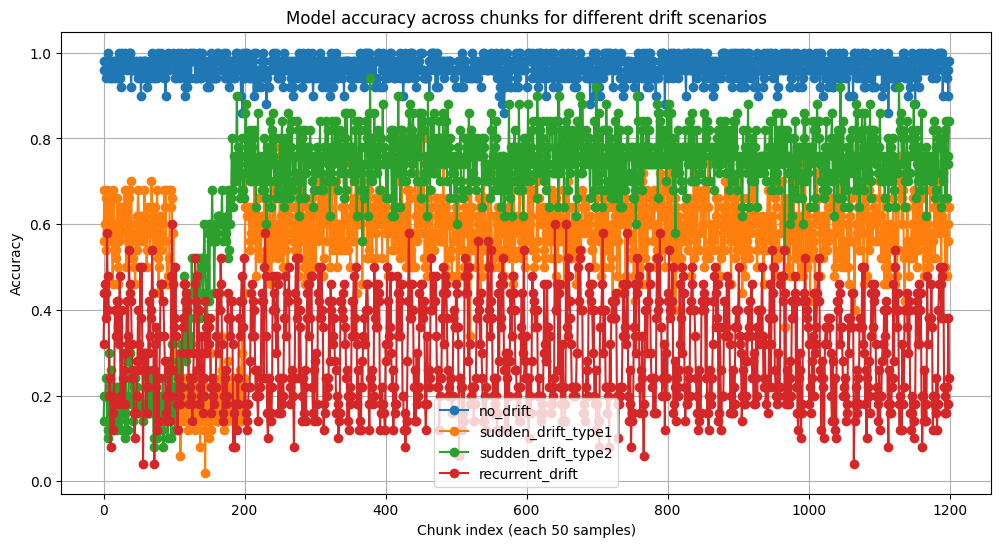

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Correct dataset dictionary names
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

features = [
    'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
    'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean', 'accelerometer_x_std',
    'accelerometer_x_mad', 'accelerometer_x_max', 'accelerometer_x_min',
    'accelerometer_x_sma', 'accelerometer_y_mean', 'accelerometer_y_std',
    'accelerometer_y_mad', 'accelerometer_y_max', 'accelerometer_y_min',
    'accelerometer_y_sma', 'accelerometer_z_mean', 'accelerometer_z_std',
    'accelerometer_z_mad', 'accelerometer_z_max', 'accelerometer_z_min',
    'accelerometer_z_sma', 'gyroscope_x_mean', 'gyroscope_x_std',
    'gyroscope_x_mad', 'gyroscope_x_max', 'gyroscope_x_min', 'gyroscope_x_sma',
    'gyroscope_y_mean', 'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
    'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean', 'gyroscope_z_std',
    'gyroscope_z_mad', 'gyroscope_z_max', 'gyroscope_z_min', 'gyroscope_z_sma'
]
target = 'activity'

scaler = StandardScaler()
chunk_size = 50  # samples per evaluation chunk

plt.figure(figsize=(12,6))

for name, df_mod in datasets.items():
    X = df_mod[features].values
    y = df_mod[target].values

    # Scale features
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(-1, len(features), 1)

    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_categorical = to_categorical(y, num_classes=num_classes)

    # Evaluate in chunks
    n_samples = X_scaled.shape[0]
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        X_chunk, y_chunk = X_scaled[start:end], y_categorical[start:end]
        if len(X_chunk) == 0:
            continue
        loss, accuracy = model.evaluate(X_chunk, y_chunk, verbose=0)
        accs.append(accuracy)

    plt.plot(range(len(accs)), accs, marker='o', label=name)

plt.title("Model accuracy across chunks for different drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


**Client Side Perfromace Drift Detction**


**Data Monitor**


In [ ]:
df_sudden_type1

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242,3,sudden_type1
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762,0,sudden_type1
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305,3,sudden_type1
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000,0,sudden_type1
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845,1,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729,2,sudden_type1
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953,0,sudden_type1
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931,1,sudden_type1
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594,3,sudden_type1


In [ ]:
df_sudden_type2

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type
0,-6.704082,2.983887,-2.233459,2.456514,1.941872,-1.308947,-0.619009,-7.366440,-3.704103,-8.833753,...,1.840160,8.635630,-3.267222,-1.458093,-2.799474,-2.766109,1.909407,-1.952948,0,sudden_type2
1,-4.462664,0.552605,-8.395338,3.243898,-1.666111,2.673364,4.996705,-4.680066,6.967212,-0.253909,...,-3.828486,3.882310,1.243349,7.646586,-4.174453,-5.559916,-1.257786,2.736155,4,sudden_type2
2,2.208331,1.928012,-2.445225,-4.495130,-0.270395,0.862733,2.508627,1.064762,7.271811,-10.510764,...,4.610120,-3.356942,-4.247614,-9.843075,-3.611678,-5.190573,5.009389,0.392784,0,sudden_type2
3,-8.697711,-1.878680,-8.364658,-5.597477,0.741130,-8.302694,-0.816686,-5.852520,-0.384091,5.600899,...,6.613828,-4.845299,10.309667,6.493449,-4.339215,-3.393780,4.865013,1.629256,2,sudden_type2
4,-0.028958,4.678717,-6.106643,6.124646,-1.112705,-6.115728,3.969675,-1.866510,-4.146045,6.609305,...,8.461463,-10.361786,-4.361331,-3.427821,-0.710794,-7.568993,-3.502338,-8.074670,3,sudden_type2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729,2,sudden_type2
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953,0,sudden_type2
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931,1,sudden_type2
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594,3,sudden_type2


In [ ]:
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'

# Step 3: Train-test split
X = df_sudden_type1[features].values
y= df_sudden_type1[target].values

# Normalize features
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
#num_classes = len(unique_labels)
#y_cat = to_categorical(y, num_classes)
y = y.reshape(-1, 1)
y_categorical = to_categorical(y, num_classes=5)
# Evaluate model
loss, accuracy = model.evaluate(X, y_categorical)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_probs = model.predict(X)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # numeric classes

# Flatten X back to original feature shape
X_flat = X.reshape(X.shape[0], X.shape[1])

# Build DataFrame with features + true label + prediction
df_results = pd.DataFrame(X_flat, columns=features)
df_results['true_activity'] = y.flatten()
df_results['predicted_activity'] = y_pred_classes

# Save if needed
df_results.to_csv('predictions_with_features.csv', index=False)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5225 - loss: 4.2502
Test Accuracy: 0.5576
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [ ]:
df_results

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,true_activity,predicted_activity
0,-0.191673,-0.302848,0.178225,-0.183398,0.226662,-0.214533,0.331286,-0.249996,-0.297491,0.198952,...,0.398144,-0.457345,0.195605,-0.127140,-0.110428,-0.408741,0.434852,-0.170774,3,3
1,-0.105961,-0.081996,-0.998474,-1.241250,0.985232,0.208680,-0.092212,-0.312117,-0.443090,-0.096399,...,0.472117,-0.238593,0.460691,0.231123,0.310718,0.019775,0.342172,0.193686,0,0
2,0.274543,-0.419934,0.832650,-0.050108,-0.154935,0.101921,0.147410,0.254831,0.276093,0.728373,...,-0.179306,-0.169632,0.344870,-0.030746,-0.044773,-0.224920,0.380838,-0.040538,3,3
3,-0.761884,-0.367788,-0.335841,-0.432243,-0.041286,-0.449191,-0.459903,-0.200305,-0.178891,-0.342913,...,0.372974,0.415553,1.099366,0.226754,0.139501,0.273693,0.256967,0.538621,0,0
4,-0.321334,-0.173021,-0.202220,-0.172987,0.142281,-0.145463,-0.092975,-0.491177,-0.497544,-0.329914,...,0.520629,-0.536452,0.151281,-0.184423,-0.166190,-0.506293,0.480456,-0.227096,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.107538,-0.706043,0.197712,-0.185752,0.118837,-0.150209,0.603310,-0.492493,-0.495054,0.102261,...,0.528246,-0.538221,0.154425,-0.184195,-0.165491,-0.502255,0.483980,-0.227520,2,1
59996,-0.898118,-0.222078,-0.167800,-0.246826,-0.055477,0.006199,-0.263157,-0.241247,-0.268498,-0.226368,...,0.359001,-0.220971,-0.421461,0.087691,-0.016289,-0.380501,0.034987,0.238317,0,0
59997,-0.315808,-0.176365,-0.056009,-0.197495,0.105960,-0.162388,-0.057703,-0.490638,-0.496948,-0.306025,...,0.512354,-0.534296,0.145792,-0.181619,-0.164650,-0.506173,0.474381,-0.223306,1,4
59998,-0.050888,-0.346033,0.310464,-0.174725,0.097749,-0.175991,0.246646,-0.314917,-0.285048,0.097637,...,0.425141,-0.452082,0.120038,-0.137970,-0.115824,-0.451786,0.434134,-0.179084,3,3


**MLaaS Extraction Model**


In [ ]:
df_results[['predicted_activity']]

,predicted_activity
0,3
1,0
2,3
3,0
4,4
...,...
59995,1
59996,0
59997,4
59998,3


Surrogate accuracy vs. black-box predictions: 0.7052


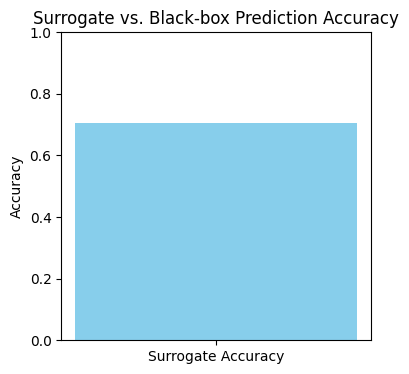

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# X = features, y_surrogate = black-box predictions
X_surrogate = df_results[features].values
y_surrogate = df_results['predicted_activity'].values
# Train surrogate (Decision Tree)
df_surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
df_surrogate.fit(X_surrogate, y_surrogate)
# Predict with surrogate
y_surrogate_pred = df_surrogate.predict(X_surrogate)
# Calculate accuracy vs. black-box predictions
acc = accuracy_score(y_surrogate, y_surrogate_pred)
print(f"Surrogate accuracy vs. black-box predictions: {acc:.4f}")
# Plot the accuracy as a simple bar
plt.figure(figsize=(4,4))
plt.bar(['Surrogate Accuracy'], [acc], color='skyblue')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Surrogate vs. Black-box Prediction Accuracy')
plt.show()

[MLaaS vs Ground Truth] Accuracy: 0.5576
[MLaaS vs Ground Truth] Macro-F1:  0.5211
[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.7027
[Surrogate vs Ground Truth] Accuracy (test): 0.5032
[Surrogate vs Ground Truth] Macro-F1 (test):  0.4749


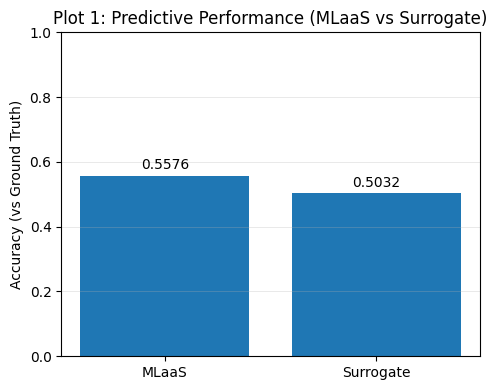

[Agreement Decomposition] Sum check: 1.000000


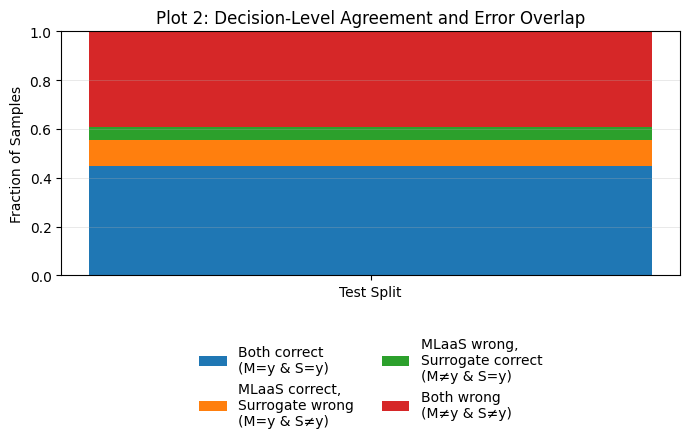


[Confusion Matrix] MLaaS vs Ground Truth (test):
[[1964  334  149  991  141]
 [ 800 1396  186  873  373]
 [ 390  253  329 2405  236]
 [  36   75  152 3243   98]
 [ 108  109  162  138 3059]]

[Confusion Matrix] Surrogate vs Ground Truth (test):
[[1552  110   61 1833   23]
 [  42 1107   72 2391   16]
 [  75  297   54 3153   34]
 [  21   63   59 3435   26]
 [  44  109   72  441 2910]]

[Classification Report] Surrogate vs Ground Truth (test):
              precision    recall  f1-score   support

           0       0.90      0.43      0.58      3579
           1       0.66      0.31      0.42      3628
           2       0.17      0.01      0.03      3613
           3       0.31      0.95      0.46      3604
           4       0.97      0.81      0.88      3576

    accuracy                           0.50     18000
   macro avg       0.60      0.50      0.47     18000
weighted avg       0.60      0.50      0.47     18000



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ============================================================
# Assumes you already have:
#   df_results with columns:
#     - features...
#     - true_activity (ground truth class id)
#     - predicted_activity (MLaaS / CNN predicted class id)
#   and `features` list
# ============================================================

# ----------------------------
# 0) Inputs
# ----------------------------
X_all = df_results[features].values
y_true = df_results["true_activity"].values          # ground truth labels
y_mlaas = df_results["predicted_activity"].values    # MLaaS labels (CNN outputs)

# Optional: if you want macro-F1 in addition to accuracy
USE_F1 = True

# ----------------------------
# 1) Evaluate MLaaS vs Ground Truth
# ----------------------------
acc_mlaas = accuracy_score(y_true, y_mlaas)
if USE_F1:
    f1_mlaas = f1_score(y_true, y_mlaas, average="macro")
print(f"[MLaaS vs Ground Truth] Accuracy: {acc_mlaas:.4f}")
if USE_F1:
    print(f"[MLaaS vs Ground Truth] Macro-F1:  {f1_mlaas:.4f}")

# ----------------------------
# 2) Train Surrogate to mimic MLaaS, then evaluate properly
#    - Train surrogate on (X -> y_mlaas) using train split
#    - Evaluate mimicry on test split
#    - Also evaluate surrogate vs ground truth on same test split
# ----------------------------
X_train, X_test, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42, stratify=y_true
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train, y_mlaas_train)

# Surrogate predictions on test
y_sur_test = surrogate.predict(X_test)

# (A) Mimicry: Surrogate vs MLaaS on test split
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# (B) Quality: Surrogate vs Ground Truth on test split
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
if USE_F1:
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")
print(f"[Surrogate vs Ground Truth] Accuracy (test): {acc_sur_gt:.4f}")
if USE_F1:
    print(f"[Surrogate vs Ground Truth] Macro-F1 (test):  {f1_sur_gt:.4f}")

# ----------------------------
# 3) Plot 1: MLaaS vs Surrogate accuracy vs Ground Truth
#    (This is per run/dataset. If you do multiple datasets, you can store arrays.)
# ----------------------------
labels = ["MLaaS", "Surrogate"]
values = [acc_mlaas, acc_sur_gt]

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy (vs Ground Truth)")
plt.title("Plot 1: Predictive Performance (MLaaS vs Surrogate)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# ----------------------------
# 4) Plot 2: Decision-level agreement/error decomposition (on the SAME test set)
#    Categories:
#      - Both correct:      (MLaaS == y_true) AND (Surrogate == y_true)
#      - MLaaS correct only:(MLaaS == y_true) AND (Surrogate != y_true)
#      - Surrogate correct only:(MLaaS != y_true) AND (Surrogate == y_true)
#      - Both wrong:        (MLaaS != y_true) AND (Surrogate != y_true)
# ----------------------------
# Need MLaaS predictions on the same test set:
# Since y_mlaas_test already corresponds to X_test, we can use it directly.

both_correct = np.mean((y_mlaas_test == y_true_test) & (y_sur_test == y_true_test))
mlaas_only   = np.mean((y_mlaas_test == y_true_test) & (y_sur_test != y_true_test))
sur_only     = np.mean((y_mlaas_test != y_true_test) & (y_sur_test == y_true_test))
both_wrong   = np.mean((y_mlaas_test != y_true_test) & (y_sur_test != y_true_test))

# Sanity check sum to 1
total = both_correct + mlaas_only + sur_only + both_wrong
print(f"[Agreement Decomposition] Sum check: {total:.6f}")

components = [both_correct, mlaas_only, sur_only, both_wrong]
names = [
    "Both correct\n(M=y & S=y)",
    "MLaaS correct,\nSurrogate wrong\n(M=y & S≠y)",
    "MLaaS wrong,\nSurrogate correct\n(M≠y & S=y)",
    "Both wrong\n(M≠y & S≠y)"
]

plt.figure(figsize=(7, 4.8))
bottom = 0.0
for c, n in zip(components, names):
    plt.bar(["Test Split"], [c], bottom=bottom, label=n)
    bottom += c

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples")
plt.title("Plot 2: Decision-Level Agreement and Error Overlap")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# ----------------------------
# 5) (Optional) Extra printouts for reviewer-friendly evidence
# ----------------------------
print("\n[Confusion Matrix] MLaaS vs Ground Truth (test):")
print(confusion_matrix(y_true_test, y_mlaas_test))

print("\n[Confusion Matrix] Surrogate vs Ground Truth (test):")
print(confusion_matrix(y_true_test, y_sur_test))

print("\n[Classification Report] Surrogate vs Ground Truth (test):")
print(classification_report(y_true_test, y_sur_test))


In [ ]:
import pandas as pd

# ============================================================
# 1) SUMMARY CSV (performance + mimicry)
# ============================================================
summary = {
    "dataset": ["HAR"],
    "mlaas_accuracy_vs_ground_truth": [acc_mlaas],
    "surrogate_accuracy_vs_ground_truth": [acc_sur_gt],
    "surrogate_mimicry_accuracy_vs_mlaas": [acc_mimic],
    "surrogate_model": ["DecisionTree"],
    "surrogate_max_depth": [4],
    "test_size": [0.30],
}

# Add F1 values only if they exist (USE_F1=True)
if "USE_F1" in globals() and USE_F1:
    summary["mlaas_macro_f1_vs_ground_truth"] = [f1_mlaas]
    summary["surrogate_macro_f1_vs_ground_truth"] = [f1_sur_gt]

df_summary = pd.DataFrame(summary)
summary_csv = "har_surrogate_fidelity_summary.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"Saved: {summary_csv}")

# ============================================================
# 2) AGREEMENT CSV (decision-level decomposition)
# ============================================================
df_agreement = pd.DataFrame([{
    "dataset": "HAR",
    "both_correct_fraction": both_correct,
    "mlaas_correct_surrogate_wrong_fraction": mlaas_only,
    "mlaas_wrong_surrogate_correct_fraction": sur_only,
    "both_wrong_fraction": both_wrong
}])

agreement_csv = "har_surrogate_agreement_decomposition.csv"
df_agreement.to_csv(agreement_csv, index=False)
print(f"Saved: {agreement_csv}")

# Preview
df_summary, df_agreement


Saved: har_surrogate_fidelity_summary.csv
Saved: har_surrogate_agreement_decomposition.csv


(  dataset  mlaas_accuracy_vs_ground_truth  surrogate_accuracy_vs_ground_truth  \
 0     HAR                        0.557583                            0.503222   
 
    surrogate_mimicry_accuracy_vs_mlaas surrogate_model  surrogate_max_depth  \
 0                             0.702667    DecisionTree                    4   
 
    test_size  mlaas_macro_f1_vs_ground_truth  \
 0        0.3                        0.521078   
 
    surrogate_macro_f1_vs_ground_truth  
 0                            0.474914  ,
   dataset  both_correct_fraction  mlaas_correct_surrogate_wrong_fraction  \
 0     HAR               0.448944                                0.106111   
 
    mlaas_wrong_surrogate_correct_fraction  both_wrong_fraction  
 0                                0.054278             0.390667  )

**Electricity Dataset**
---

In [ ]:
!pip install frouros

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from frouros.datasets.real import Elec2
from frouros.detectors.concept_drift import DDM, DDMConfig

elec2 = Elec2()
elec2.download()
data = elec2.load()
data
X = np.array(data[["nswprice", "vicprice", "transfer","vicdemand"]].tolist())
y = np.array(data[["class"]].tolist()).astype("str")
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(X, columns=["nswprice", "vicprice", "transfer","vicdemand"])
df["class"] = y

df.shape
df.to_csv("Electricity.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


# === Split features and target ===
X = df[["nswprice", "vicprice", "transfer", "vicdemand"]]
y = df["class"]

# === Encode labels ===
le = LabelEncoder()
y = le.fit_transform(y)

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === Scale features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Simple Neural Network ===
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                      solver='adam', max_iter=300, random_state=42)

# === Train ===
model.fit(X_train, y_train)

# === Predict ===
y_pred = model.predict(X_test)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[6677 1136]
 [1999 3782]]


In [ ]:
import pandas as pd

# ============================================================
# Store Experiment-3 Results (Single Dataset / Run)
# ============================================================

results_dict = {
    "dataset": ["HAR"],  # change name if needed

    # Performance vs Ground Truth
    "mlaas_accuracy_gt": [acc_mlaas],
    "surrogate_accuracy_gt": [acc_sur_gt],

    # Mimicry fidelity
    "surrogate_mimicry_accuracy": [acc_mimic],

    # Decision-level agreement decomposition
    "both_correct_fraction": [both_correct],
    "mlaas_correct_surrogate_wrong_fraction": [mlaas_only],
    "mlaas_wrong_surrogate_correct_fraction": [sur_only],
    "both_wrong_fraction": [both_wrong]
}

df_experiment_results = pd.DataFrame(results_dict)

# ============================================================
# Save to CSV
# ============================================================
csv_path = "experiment3_mlaas_surrogate_fidelity_results.csv"
df_experiment_results.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")
df_experiment_results5

**Electricity Drift Injection**


In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "Electricity.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("har_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("ele_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("ele_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("ele_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

In [ ]:
import pandas as pd

# Load the datasets
df_sudden_type1 = pd.read_csv("/content/ele_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/ele_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("ele_recurrent_drift.csv")
df_nodrift      = pd.read_csv("har_no_drift.csv")

# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"

# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

Merged dataset saved to 'har_all_drifts.csv'


In [ ]:
df_sudden_type1

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type
0,0.0,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1
1,1.0,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1
2,2.0,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1
3,3.0,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1
4,4.0,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1
...,...,...,...,...,...,...,...
45307,45307.0,0.044224,0.003033,0.405263,0.255049,DOWN,sudden_type1
45308,45308.0,0.044884,0.003072,0.420614,0.241326,DOWN,sudden_type1
45309,45309.0,0.043593,0.002983,0.362281,0.247799,DOWN,sudden_type1
45310,45310.0,0.066651,0.004630,0.206579,0.345417,UP,sudden_type1


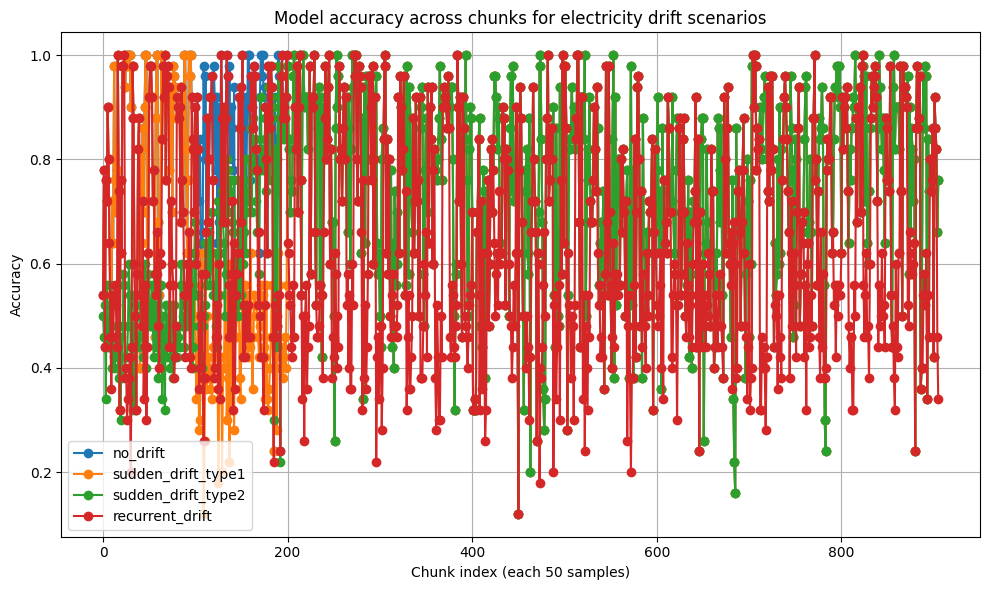

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(X, columns=["nswprice", "vicprice", "transfer","vicdemand"])
df["class"] = y


# ===================================================
# assume these dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

features = ["nswprice", "vicprice", "transfer", "vicdemand"]

target = "class"
chunk_size = 50

# ===================================================
# load main electricity dataset and train model
# ===================================================
X = df[features].values
y = LabelEncoder().fit_transform(df[target].values)

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)

model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                      solver='adam', max_iter=300, random_state=42)
model.fit(X_train, y_train)

# ===================================================
# Evaluate trained model on each drift dataset
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod = df_mod[features].values
    y_mod = LabelEncoder().fit_transform(df_mod[target].values)

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Model accuracy across chunks for electricity drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_sudden_type1

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type
0,0.0,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1
1,1.0,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1
2,2.0,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1
3,3.0,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1
4,4.0,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1
...,...,...,...,...,...,...,...
45307,45307.0,0.044224,0.003033,0.405263,0.255049,DOWN,sudden_type1
45308,45308.0,0.044884,0.003072,0.420614,0.241326,DOWN,sudden_type1
45309,45309.0,0.043593,0.002983,0.362281,0.247799,DOWN,sudden_type1
45310,45310.0,0.066651,0.004630,0.206579,0.345417,UP,sudden_type1


[MLaaS vs GT] Test Accuracy: 0.7272

[MLaaS Confusion Matrix]
[[6255 1499]
 [2210 3630]]

Saved test predictions to: electricity_predictions_with_features.csv
   nswprice  vicprice  transfer  vicdemand true_class predicted_class
0 -0.039079  0.003467  0.414912   0.422915         UP              UP
1  0.073226  0.005147  0.446491   0.665976         UP              UP
2  0.079560  0.003467  0.414912   0.422915         UP              UP
3  0.047316  0.003137  0.568860   0.300104       DOWN            DOWN
4  0.131290  0.009011  0.302632   0.483687         UP              UP

Saved fidelity curve to: electricity_surrogate_fidelity_every_500.csv
       dataset  num_samples_used  surrogate_mimicry_accuracy  \
0  Electricity               500                    0.953333   
1  Electricity              1000                    0.943333   
2  Electricity              1500                    0.944444   
3  Electricity              2000                    0.970000   
4  Electricity              25

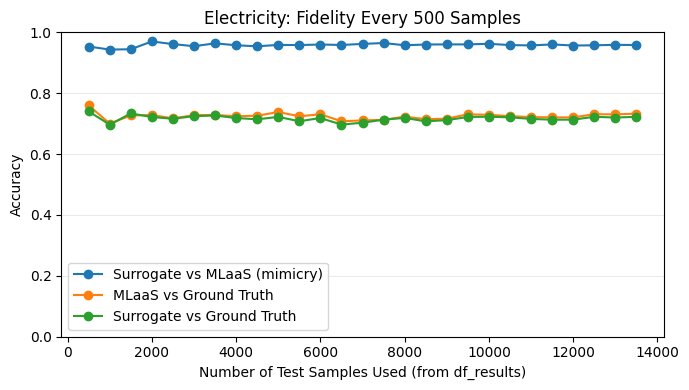

In [ ]:
# ============================================================
# ELECTRICITY DATASET: MLaaS (Black-box) + Surrogate Fidelity
# - Train black-box (MLPClassifier) on Electricity features
# - Save test-set predictions with features (df_results)
# - For every 500 samples (from df_results), train DecisionTree surrogate
#   to mimic black-box predictions and compute:
#     (1) Surrogate mimicry accuracy (Surrogate vs MLaaS)
#     (2) MLaaS accuracy vs Ground Truth
#     (3) Surrogate accuracy vs Ground Truth
# - Store all values to CSV
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# ============================================================
# 0) LOAD DATA
# ============================================================
# Option A: you already have df_sudden_type1 in memory (as in your code)
df = df_sudden_type1.copy()

# Option B: if you want to load from CSV, uncomment and set your path
# df = pd.read_csv("elec.csv")

# Clean
df.columns = [c.strip() for c in df.columns]
df = df.dropna().reset_index(drop=True)

# ============================================================
# 1) CONFIG (Electricity features/target)
# ============================================================
features = ["nswprice", "vicprice", "transfer", "vicdemand"]
target = "class"

# Ensure required cols exist
missing_cols = [c for c in features + [target] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in df: {missing_cols}")

X = df[features].values
y = df[target].values

# ============================================================
# 2) ENCODE LABELS + TRAIN/TEST SPLIT
# ============================================================
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)

# ============================================================
# 3) SCALE FEATURES
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# 4) BLACK-BOX MODEL (MLP = your MLaaS)
# ============================================================
mlaas_model = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)
mlaas_model.fit(X_train_scaled, y_train)

# MLaaS predictions on test
y_pred_test = mlaas_model.predict(X_test_scaled)

# MLaaS accuracy vs ground truth
mlaas_acc_gt = accuracy_score(y_test, y_pred_test)
print(f"[MLaaS vs GT] Test Accuracy: {mlaas_acc_gt:.4f}")

print("\n[MLaaS Confusion Matrix]")
print(confusion_matrix(y_test, y_pred_test))

# ============================================================
# 5) BUILD df_results (features + true + predicted)
#    NOTE: store ORIGINAL (unscaled) feature values for readability
# ============================================================
df_results = pd.DataFrame(X_test, columns=features)
df_results["true_class"] = le.inverse_transform(y_test)
df_results["predicted_class"] = le.inverse_transform(y_pred_test)

# Save full predictions
df_results_path = "electricity_predictions_with_features.csv"
df_results.to_csv(df_results_path, index=False)
print(f"\nSaved test predictions to: {df_results_path}")
print(df_results.head())

# ============================================================
# 6) SURROGATE FIDELITY EVERY 500 SAMPLES + SAVE CSV
# ============================================================
STEP = 500
TEST_SIZE = 0.30
RANDOM_STATE = 42
MAX_DEPTH = 4

# Encode labels once for consistency across slices
le_pred = LabelEncoder()
y_mlaas_all = le_pred.fit_transform(df_results["predicted_class"].values)  # MLaaS labels (numeric)

le_true = LabelEncoder()
y_true_all = le_true.fit_transform(df_results["true_class"].values)        # GT labels (numeric)

X_all = df_results[features].values
n_total = len(df_results)

rows = []

# If test set is smaller than 500, still compute once using all samples
if n_total < STEP:
    slice_points = [n_total]
else:
    slice_points = list(range(STEP, n_total + 1, STEP))

for n in slice_points:
    X_n = X_all[:n]
    y_mlaas_n = y_mlaas_all[:n]
    y_true_n = y_true_all[:n]

    # split inside the slice (stratify by ground truth for stability)
    X_tr, X_te, y_mlaas_tr, y_mlaas_te, y_true_tr, y_true_te = train_test_split(
        X_n, y_mlaas_n, y_true_n,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_true_n
    )

    # Train surrogate to mimic MLaaS predictions
    surrogate = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
    surrogate.fit(X_tr, y_mlaas_tr)

    # Predict surrogate on test
    y_sur_te = surrogate.predict(X_te)

    # (1) Surrogate vs MLaaS mimicry accuracy
    mimic_acc = accuracy_score(y_mlaas_te, y_sur_te)

    # (2) MLaaS vs GT accuracy (same test samples)
    mlaas_acc = accuracy_score(y_true_te, y_mlaas_te)

    # (3) Surrogate vs GT accuracy (same test samples)
    sur_acc = accuracy_score(y_true_te, y_sur_te)

    rows.append({
        "dataset": "Electricity",
        "num_samples_used": int(n),
        "surrogate_mimicry_accuracy": round(float(mimic_acc), 6),
        "mlaas_accuracy_vs_ground_truth": round(float(mlaas_acc), 6),
        "surrogate_accuracy_vs_ground_truth": round(float(sur_acc), 6),
        "surrogate_max_depth": MAX_DEPTH,
        "test_size": TEST_SIZE
    })

df_fidelity = pd.DataFrame(rows)

out_csv = "electricity_surrogate_fidelity_every_500.csv"
df_fidelity.to_csv(out_csv, index=False)

print(f"\nSaved fidelity curve to: {out_csv}")
print(df_fidelity.head())
print(df_fidelity.tail())



[MLaaS vs Ground Truth] Accuracy: 0.7272
[MLaaS vs Ground Truth] Macro-F1:  0.7166
[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.9581
[Surrogate vs Ground Truth] Accuracy (test): 0.7213
[Surrogate vs Ground Truth] Macro-F1 (test):  0.7078


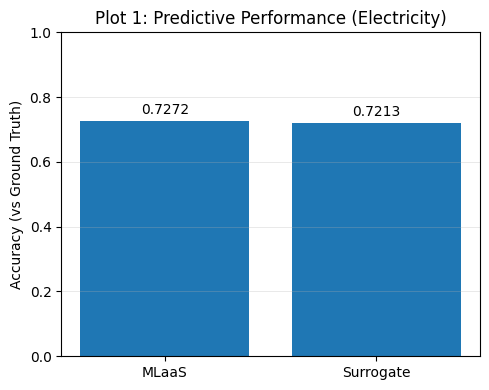

[Agreement Decomposition] Sum check: 1.000000


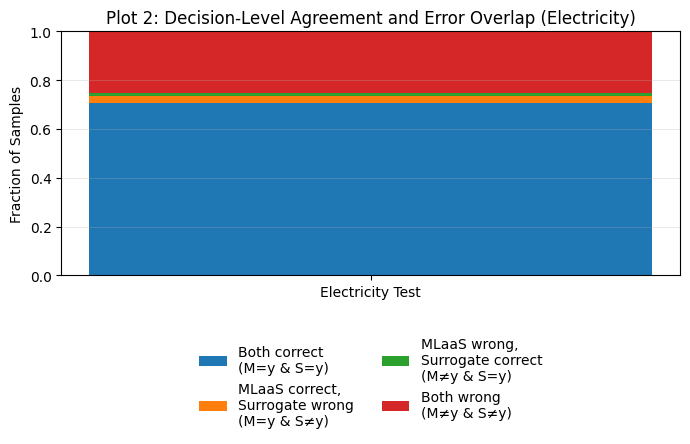


[Confusion Matrix] MLaaS vs Ground Truth (test):
[[1884  443]
 [ 641 1111]]

[Confusion Matrix] Surrogate vs Ground Truth (test):
[[1909  418]
 [ 719 1033]]

[Classification Report] Surrogate vs Ground Truth (test):
              precision    recall  f1-score   support

           0     0.7264    0.8204    0.7705      2327
           1     0.7119    0.5896    0.6450      1752

    accuracy                         0.7213      4079
   macro avg     0.7192    0.7050    0.7078      4079
weighted avg     0.7202    0.7213    0.7166      4079



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ============================================================
# ELECTRICITY VERSION
# Assumes you already have df_results with columns:
#   - nswprice, vicprice, transfer, vicdemand
#   - true_class (ground truth label, can be string)
#   - predicted_class (MLaaS / black-box label, can be string)
# ============================================================

# ----------------------------
# 0) Inputs
# ----------------------------
features = ["nswprice", "vicprice", "transfer", "vicdemand"]

X_all = df_results[features].values

# Encode labels to numeric (important!)
le_true = LabelEncoder()
y_true = le_true.fit_transform(df_results["true_class"].values)

le_mlaas = LabelEncoder()
y_mlaas = le_mlaas.fit_transform(df_results["predicted_class"].values)

USE_F1 = True

# ----------------------------
# 1) Evaluate MLaaS vs Ground Truth (on all df_results)
# ----------------------------
acc_mlaas = accuracy_score(y_true, y_mlaas)
if USE_F1:
    f1_mlaas = f1_score(y_true, y_mlaas, average="macro")

print(f"[MLaaS vs Ground Truth] Accuracy: {acc_mlaas:.4f}")
if USE_F1:
    print(f"[MLaaS vs Ground Truth] Macro-F1:  {f1_mlaas:.4f}")

# ----------------------------
# 2) Train Surrogate to mimic MLaaS, then evaluate properly
# ----------------------------
X_train, X_test, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42, stratify=y_true
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train, y_mlaas_train)

# Surrogate predictions on test
y_sur_test = surrogate.predict(X_test)

# (A) Mimicry: Surrogate vs MLaaS on test split
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# (B) Quality: Surrogate vs Ground Truth on test split
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
if USE_F1:
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")

print(f"[Surrogate vs Ground Truth] Accuracy (test): {acc_sur_gt:.4f}")
if USE_F1:
    print(f"[Surrogate vs Ground Truth] Macro-F1 (test):  {f1_sur_gt:.4f}")

# ----------------------------
# 3) Plot 1: MLaaS vs Surrogate accuracy vs Ground Truth
# ----------------------------
labels = ["MLaaS", "Surrogate"]
values = [acc_mlaas, acc_sur_gt]

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy (vs Ground Truth)")
plt.title("Plot 1: Predictive Performance (Electricity)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# ----------------------------
# 4) Plot 2: Decision-level agreement/error decomposition (same test split)
# ----------------------------
both_correct = np.mean((y_mlaas_test == y_true_test) & (y_sur_test == y_true_test))
mlaas_only   = np.mean((y_mlaas_test == y_true_test) & (y_sur_test != y_true_test))
sur_only     = np.mean((y_mlaas_test != y_true_test) & (y_sur_test == y_true_test))
both_wrong   = np.mean((y_mlaas_test != y_true_test) & (y_sur_test != y_true_test))

total = both_correct + mlaas_only + sur_only + both_wrong
print(f"[Agreement Decomposition] Sum check: {total:.6f}")

components = [both_correct, mlaas_only, sur_only, both_wrong]
names = [
    "Both correct\n(M=y & S=y)",
    "MLaaS correct,\nSurrogate wrong\n(M=y & S≠y)",
    "MLaaS wrong,\nSurrogate correct\n(M≠y & S=y)",
    "Both wrong\n(M≠y & S≠y)"
]

plt.figure(figsize=(7, 4.8))
bottom = 0.0
for c, n in zip(components, names):
    plt.bar(["Electricity Test"], [c], bottom=bottom, label=n)
    bottom += c

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples")
plt.title("Plot 2: Decision-Level Agreement and Error Overlap (Electricity)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# ----------------------------
# 5) Extra printouts (reviewer-friendly)
# ----------------------------
print("\n[Confusion Matrix] MLaaS vs Ground Truth (test):")
print(confusion_matrix(y_true_test, y_mlaas_test))

print("\n[Confusion Matrix] Surrogate vs Ground Truth (test):")
print(confusion_matrix(y_true_test, y_sur_test))

print("\n[Classification Report] Surrogate vs Ground Truth (test):")
print(classification_report(y_true_test, y_sur_test, digits=4))


In [ ]:
import pandas as pd

# ============================================================
# CSV 1: Overall Accuracy & Mimicry Summary
# ============================================================

summary_results = {
    "dataset": ["Electricity"],

    # MLaaS quality
    "mlaas_accuracy_vs_ground_truth": [acc_mlaas],
    "mlaas_macro_f1_vs_ground_truth": [f1_mlaas],

    # Surrogate quality
    "surrogate_accuracy_vs_ground_truth": [acc_sur_gt],
    "surrogate_macro_f1_vs_ground_truth": [f1_sur_gt],

    # Mimicry fidelity
    "surrogate_mimicry_accuracy_vs_mlaas": [acc_mimic],

    # Surrogate configuration
    "surrogate_model": ["DecisionTree"],
    "surrogate_max_depth": [4],
    "test_split_ratio": [0.30]
}

df_summary = pd.DataFrame(summary_results)

summary_csv = "electricity_surrogate_fidelity_summary.csv"
df_summary.to_csv(summary_csv, index=False)

print(f"Saved summary results to: {summary_csv}")
df_summary


Saved summary results to: electricity_surrogate_fidelity_summary.csv


,dataset,mlaas_accuracy_vs_ground_truth,mlaas_macro_f1_vs_ground_truth,surrogate_accuracy_vs_ground_truth,surrogate_macro_f1_vs_ground_truth,surrogate_mimicry_accuracy_vs_mlaas,surrogate_model,surrogate_max_depth,test_split_ratio
0,Electricity,0.727159,0.716591,0.721255,0.707778,0.958078,DecisionTree,4,0.3


In [ ]:
# ============================================================
# CSV 2: Decision-Level Agreement Decomposition
# ============================================================

agreement_results = {
    "dataset": ["Electricity"],

    "both_correct_fraction": [both_correct],
    "mlaas_correct_surrogate_wrong_fraction": [mlaas_only],
    "mlaas_wrong_surrogate_correct_fraction": [sur_only],
    "both_wrong_fraction": [both_wrong]
}

df_agreement = pd.DataFrame(agreement_results)

agreement_csv = "electricity_surrogate_agreement_decomposition.csv"
df_agreement.to_csv(agreement_csv, index=False)

print(f"Saved agreement decomposition to: {agreement_csv}")
df_agreement


Saved agreement decomposition to: electricity_surrogate_agreement_decomposition.csv


,dataset,both_correct_fraction,mlaas_correct_surrogate_wrong_fraction,mlaas_wrong_surrogate_correct_fraction,both_wrong_fraction
0,Electricity,0.706791,0.027458,0.014464,0.251287


**Poke**
---

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
poker_hand = fetch_ucirepo(id=158)

# data (as pandas dataframes)
X = poker_hand.data.features
y = poker_hand.data.targets

# metadata
print(poker_hand.metadata)

# variable information
print(poker_hand.variables)

{'uci_id': 158, 'name': 'Poker Hand', 'repository_url': 'https://archive.ics.uci.edu/dataset/158/poker+hand', 'data_url': 'https://archive.ics.uci.edu/static/public/158/data.csv', 'abstract': 'Purpose is to predict poker hands', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1025010, 'num_features': 10, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['CLASS'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2002, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5KW38', 'creators': ['Robert Cattral', 'Franz Oppacher'], 'intro_paper': None, 'additional_info': {'summary': 'Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. There is one Class attribute that describes the "Poker Hand". T

In [ ]:
# ============================================================
# Poker Hand Dataset – ANN Classification (Single Cell)
# Uses existing X and y → rebuilds df → trains ANN
# ============================================================

# === Import Libraries ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# Step 0: Reconstruct DataFrame from existing X and y
# ============================================================

feature_columns = [
    'S1', 'C1',
    'S2', 'C2',
    'S3', 'C3',
    'S4', 'C4',
    'S5', 'C5'
]

# Build dataframe exactly like the weather pipeline
df = pd.DataFrame(X, columns=feature_columns)

# Handle y whether Series or DataFrame
df['CLASS'] = y.iloc[:, 0].values if isinstance(y, pd.DataFrame) else y

# ============================================================
# Step 1: Select Features and Target
# ============================================================

X = df[feature_columns]
y = df['CLASS']

# ============================================================
# Step 2: Train–Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ============================================================
# Step 3: Feature Scaling
# ============================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ============================================================
# Step 4: Build ANN Model (Multi-class: 10 poker hands)
# ============================================================

num_classes = df['CLASS'].nunique()

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# ============================================================
# Step 5: Compile Model
# ============================================================

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================================
# Step 6: Train Model
# ============================================================

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# ============================================================
# Step 7: Evaluate Model
# ============================================================

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
df = df.sample(n=200000, random_state=42)
df.to_csv("drift.csv")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
17938/17938 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.5333 - loss: 0.9724 - val_accuracy: 0.6083 - val_loss: 0.8644
Epoch 2/5
17938/17938 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.6115 - loss: 0.8559 - val_accuracy: 0.7156 - val_loss: 0.6984
Epoch 3/5
17938/17938 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6867 - loss: 0.7452 - val_accuracy: 0.7855 - val_loss: 0.5675
Epoch 4/5
17938/17938 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.7382 - loss: 0.6597 - val_accuracy: 0.8164 - val_loss: 0.4823
Epoch 5/5
17938/17938 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - accuracy: 0.7634 - loss: 0.6105 - val_accuracy: 0.8449 - val_loss: 0.4104
9610/9610 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step

✅ Confusion Matrix:
[[154064     47      0      0      0      0      0      0      0      0]
 [ 28703 101226      0      0      0      0      0      0      0      0]
 [   149  13413    872    215      0      0      0      0      0      0]
 [     0   2714    458   3317      0      0      1      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Drift Injection**


In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "drift.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("poke_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("poke_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("poke_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("poke_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

In [ ]:
import pandas as pd
# Load the datasets
df_sudden_type1 = pd.read_csv("/content/poke_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/poke_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("poke_recurrent_drift.csv")
df_nodrift      = pd.read_csv("poke_no_drift.csv")
# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"
# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("poker_all_drifts.csv", index=False)

print("Merged dataset saved to 'poker_all_drifts.csv'")

Merged dataset saved to 'poker_all_drifts.csv'


In [ ]:
df_sudden_type1

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,CLASS,drift_type
0,861551.0,3.0,11.0,3.0,4.0,2.0,11.0,1.0,1.0,1.0,2.0,1,sudden_type1
1,194889.0,1.0,1.0,1.0,7.0,1.0,4.0,1.0,12.0,3.0,5.0,0,sudden_type1
2,538854.0,4.0,9.0,4.0,4.0,1.0,3.0,2.0,1.0,2.0,13.0,0,sudden_type1
3,108766.0,4.0,6.0,2.0,11.0,2.0,2.0,1.0,8.0,3.0,2.0,1,sudden_type1
4,791613.0,2.0,5.0,3.0,11.0,4.0,11.0,3.0,2.0,3.0,4.0,1,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,168360.0,4.0,9.0,2.0,2.0,3.0,2.0,1.0,10.0,4.0,13.0,1,sudden_type1
199996,903006.0,2.0,2.0,2.0,6.0,1.0,13.0,2.0,5.0,2.0,11.0,0,sudden_type1
199997,238715.0,1.0,5.0,3.0,4.0,4.0,3.0,3.0,13.0,3.0,2.0,0,sudden_type1
199998,444143.0,2.0,9.0,3.0,2.0,2.0,2.0,2.0,5.0,3.0,6.0,1,sudden_type1


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Base test accuracy (no_drift split): 0.6758166666666666


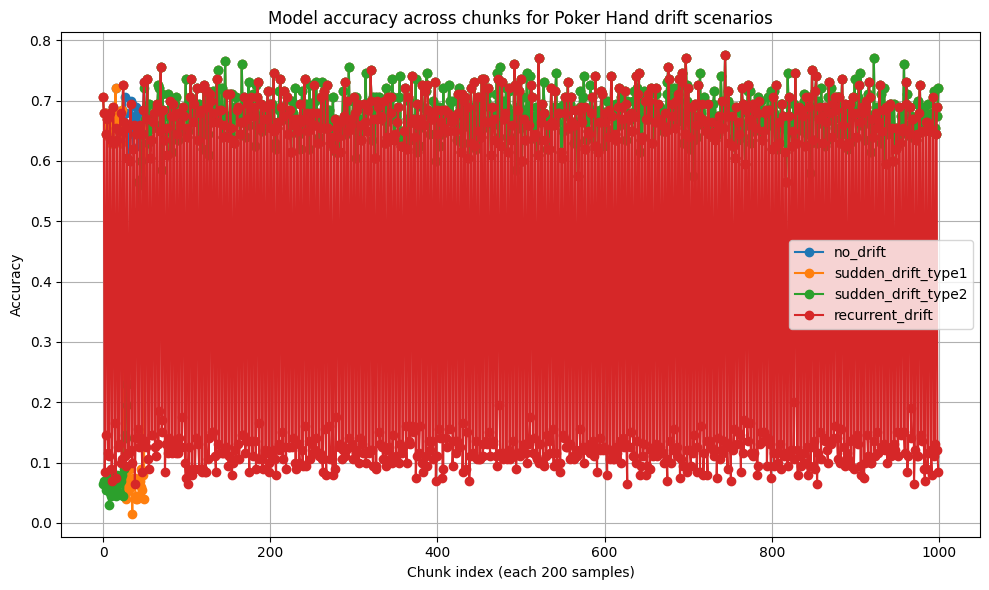

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# ===================================================
# assume these POKER drift dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

# ===================================================
# define features and target (POKER HAND)
# ===================================================
features = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5']
target = "CLASS"   # 0..9 (10-way)

chunk_size = 200

# ===================================================
# load main poker dataset and train model
# ===================================================
# NOTE: df should be your base dataset (e.g., df_nodrift)
df = df_nodrift.copy()

X = df[features].values
y = df[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# model (same architecture)
model = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
model.fit(X_train, y_train)

# quick base test accuracy (optional)
y_test_pred = model.predict(X_test)
print("Base test accuracy (no_drift split):", accuracy_score(y_test, y_test_pred))

# ===================================================
# Evaluate trained model on each drift dataset
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod = df_mod[features].values
    y_mod = df_mod[target].values

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Model accuracy across chunks for Poker Hand drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ============================================================
# POKER HAND ANN: Train + Predict + Save Predictions (Like Weather Code)
# Uses df_sudden_type1 (Poker drift dataframe) and saves CSV
# ============================================================

# === Load your dataset (Poker drift dataframe) ===
df = df_sudden_type1.copy()   # must contain S1,C1,...,S5,C5 and CLASS

# === Define features and target (Poker) ===
features = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5']
target = "CLASS"

# === Drop missing values (kept for consistency) ===
df = df.dropna()

# === Split features and target ===
X = df[features]
y = df[target].astype(int)   # Poker labels are 0..9

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === Feature Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# Build ANN Model (Multi-class Poker: 10-way softmax)
# (Matches the "current format/current model" you used earlier)
# ============================================================
num_classes = int(df[target].nunique())  # should be 10

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# === Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Train Model ===
history = model.fit(
    X_train_scaled, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# === Predict ===
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1).astype(int)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ============================================================
# Save results (features + true label + predicted label)
# ============================================================
df_results = pd.DataFrame(X_test.values, columns=features)
df_results["true_class"] = y_test.values
df_results["predicted_class"] = y_pred

# Optional: also store max confidence
df_results["pred_confidence"] = np.max(y_pred_prob, axis=1)

# === Save results ===
out_file = "poker_ann_predictions.csv"
df_results.to_csv(out_file, index=False)
print(f"\nPredictions saved to: {out_file}")

# === Preview ===
print("\nSample predictions:")
print(df_results.head())


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.4936 - loss: 1.1307 - val_accuracy: 0.5296 - val_loss: 0.9828
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5291 - loss: 1.0015 - val_accuracy: 0.5347 - val_loss: 0.9755
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5298 - loss: 0.9936 - val_accuracy: 0.5394 - val_loss: 0.9656
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5415 - loss: 0.9779 - val_accuracy: 0.5491 - val_loss: 0.9547
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5449 - loss: 0.9724 - val_accuracy: 0.5548 - val_loss: 0.9463
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step

Confusion Matrix:
[[25900  3366     0     0     1     1     2     1    18    40]
 [17525  7278     0     1     1     0     1     0    10    70]
 [ 1512  1266     1     0     1     1     6     0    34   106]
 [  451   822     0     1     1     0     4     1    29   104]
 [   13   239     2     4     2     2     5    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================
# POKER: Load dataframe
# ============================================================
df = df_sudden_type1.copy()   # must contain S1,C1,...,S5,C5 and CLASS
df.columns = [c.strip() for c in df.columns]
df = df.dropna().reset_index(drop=True)

# ============================================================
# POKER: features/target
# ============================================================
features = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5']
target = "CLASS"

# Ensure numeric
df[target] = df[target].astype(int)

X = df[features].values
y = df[target].values  # 0..9

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

num_classes = len(np.unique(y))
print("num_classes:", num_classes)
print("Train size:", X_train_scaled.shape, "Test size:", X_test_scaled.shape)


num_classes: 10
Train size: (140000, 10) Test size: (60000, 10)


In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ============================================================
# Build ANN Model (Poker: multi-class softmax)
# ============================================================
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predict (MLaaS outputs)
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1).astype(int)

# Confusion matrix (MLaaS vs GT)
cm = confusion_matrix(y_test, y_pred)
print("\n[MLaaS Confusion Matrix]")
print(cm)

# Build df_results (unscaled features + true + predicted)
df_results = pd.DataFrame(X_test, columns=features)
df_results["true_class"] = y_test
df_results["predicted_class"] = y_pred
df_results["pred_confidence"] = np.max(y_pred_prob, axis=1)

# Save predictions
pred_csv = "poker_predictions_with_features.csv"
df_results.to_csv(pred_csv, index=False)
print(f"\nSaved: {pred_csv}")
df_results.head()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.4985 - loss: 1.1260 - val_accuracy: 0.5248 - val_loss: 0.9897
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5271 - loss: 0.9964 - val_accuracy: 0.5309 - val_loss: 0.9795
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5309 - loss: 0.9904 - val_accuracy: 0.5392 - val_loss: 0.9690
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5363 - loss: 0.9832 - val_accuracy: 0.5415 - val_loss: 0.9619
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.5471 - loss: 0.9716 - val_accuracy: 0.5556 - val_loss: 0.9480
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

[MLaaS Confusion Matrix]
[[25153  4107     0     0     0     2     1    61     4     1]
 [16519  8280     1     0     1     0     1    82     1     1]
 [ 1422  1344     1     0     4     3     5   142     5     1]
 [  446   828     0     1     4     1     4   122     4     3]
 [    5   233     2     1   

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,true_class,predicted_class,pred_confidence
0,2.0,12.0,2.0,10.0,1.0,7.0,1.0,12.0,2.0,3.0,1,0,0.529864
1,1.0,5.0,3.0,9.0,1.0,7.0,2.0,11.0,1.0,13.0,0,0,0.566847
2,2.0,7.0,1.0,11.0,4.0,5.0,4.0,6.0,4.0,4.0,0,0,0.509136
3,1.0,3.0,4.0,1.0,4.0,9.0,1.0,5.0,3.0,2.0,0,1,0.541638
4,2.0,8.0,2.0,9.0,1.0,7.0,4.0,11.0,3.0,10.0,4,1,0.582761


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

USE_F1 = True

y_true_all = df_results["true_class"].values
y_mlaas_all = df_results["predicted_class"].values

acc_mlaas = accuracy_score(y_true_all, y_mlaas_all)
print(f"[MLaaS vs GT] Accuracy: {acc_mlaas:.4f}")

if USE_F1:
    f1_mlaas = f1_score(y_true_all, y_mlaas_all, average="macro")
    print(f"[MLaaS vs GT] Macro-F1:  {f1_mlaas:.4f}")


[MLaaS vs GT] Accuracy: 0.5597
[MLaaS vs GT] Macro-F1:  0.1373


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

X_all = df_results[features].values
y_true = df_results["true_class"].values
y_mlaas = df_results["predicted_class"].values

# Split once for surrogate evaluation (IMPORTANT: no train=test cheating)
X_train_s, X_test_s, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42, stratify=y_true
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train_s, y_mlaas_train)

y_sur_test = surrogate.predict(X_test_s)

# Mimicry fidelity: surrogate vs MLaaS
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# Surrogate quality vs ground truth
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
print(f"[Surrogate vs GT] Accuracy (test): {acc_sur_gt:.4f}")

if USE_F1:
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")
    print(f"[Surrogate vs GT] Macro-F1 (test):  {f1_sur_gt:.4f}")


[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.7490
[Surrogate vs GT] Accuracy (test): 0.4904
[Surrogate vs GT] Macro-F1 (test):  0.0881


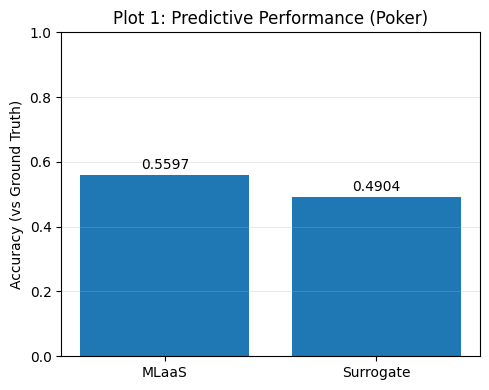

[Agreement Decomposition] Sum check: 1.000000


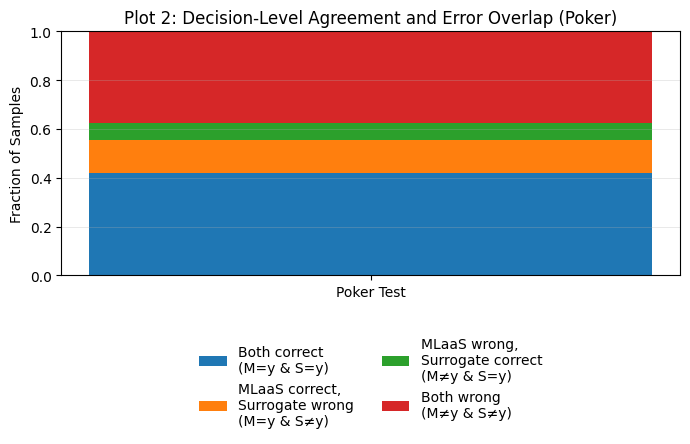

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Plot 1: MLaaS vs Surrogate accuracy vs GT
# ----------------------------
labels = ["MLaaS", "Surrogate"]
values = [acc_mlaas, acc_sur_gt]

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy (vs Ground Truth)")
plt.title("Plot 1: Predictive Performance (Poker)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Agreement/error decomposition (same test split)
# ----------------------------
both_correct = np.mean((y_mlaas_test == y_true_test) & (y_sur_test == y_true_test))
mlaas_only   = np.mean((y_mlaas_test == y_true_test) & (y_sur_test != y_true_test))
sur_only     = np.mean((y_mlaas_test != y_true_test) & (y_sur_test == y_true_test))
both_wrong   = np.mean((y_mlaas_test != y_true_test) & (y_sur_test != y_true_test))

total = both_correct + mlaas_only + sur_only + both_wrong
print(f"[Agreement Decomposition] Sum check: {total:.6f}")

components = [both_correct, mlaas_only, sur_only, both_wrong]
names = [
    "Both correct\n(M=y & S=y)",
    "MLaaS correct,\nSurrogate wrong\n(M=y & S≠y)",
    "MLaaS wrong,\nSurrogate correct\n(M≠y & S=y)",
    "Both wrong\n(M≠y & S≠y)"
]
plt.figure(figsize=(7, 4.8))
bottom = 0.0
for c, n in zip(components, names):
    plt.bar(["Poker Test"], [c], bottom=bottom, label=n)
    bottom += c

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples")
plt.title("Plot 2: Decision-Level Agreement and Error Overlap (Poker)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# ===========================
# Summary CSV
# ===========================
summary_dict = {
    "dataset": ["Poker"],
    "mlaas_accuracy_vs_ground_truth": [acc_mlaas],
    "surrogate_accuracy_vs_ground_truth": [acc_sur_gt],
    "surrogate_mimicry_accuracy_vs_mlaas": [acc_mimic],
    "surrogate_max_depth": [4],
    "test_size": [0.30]
}

if USE_F1:
    summary_dict["mlaas_macro_f1_vs_ground_truth"] = [f1_mlaas]
    summary_dict["surrogate_macro_f1_vs_ground_truth"] = [f1_sur_gt]

df_summary = pd.DataFrame(summary_dict)
summary_csv = "poker_surrogate_fidelity_summary.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"Saved: {summary_csv}")

# ===========================
# Agreement CSV
# ===========================
df_agreement = pd.DataFrame([{
    "dataset": "Poker",
    "both_correct_fraction": both_correct,
    "mlaas_correct_surrogate_wrong_fraction": mlaas_only,
    "mlaas_wrong_surrogate_correct_fraction": sur_only,
    "both_wrong_fraction": both_wrong
}])

agreement_csv = "poker_surrogate_agreement_decomposition.csv"
df_agreement.to_csv(agreement_csv, index=False)
print(f"Saved: {agreement_csv}")

df_summary, df_agreement


Saved: poker_surrogate_fidelity_summary.csv
Saved: poker_surrogate_agreement_decomposition.csv


(  dataset  mlaas_accuracy_vs_ground_truth  surrogate_accuracy_vs_ground_truth  \
 0   Poker                        0.559733                            0.490389   
 
    surrogate_mimicry_accuracy_vs_mlaas  surrogate_max_depth  test_size  \
 0                                0.749                    4        0.3   
 
    mlaas_macro_f1_vs_ground_truth  surrogate_macro_f1_vs_ground_truth  
 0                        0.137253                            0.088082  ,
   dataset  both_correct_fraction  mlaas_correct_surrogate_wrong_fraction  \
 0   Poker               0.420667                                0.135556   
 
    mlaas_wrong_surrogate_correct_fraction  both_wrong_fraction  
 0                                0.069722             0.374056  )

**Airline**
---

In [ ]:
from google.colab import drive
import pandas as pd
#rive.mount('/content/drive')
df = pd.read_csv("/content/air_2019.csv")
df

,Unnamed: 0,Year,Month,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,total_delay
0,0,2000,7,1,830,926,56.0,224,47.619856,-117.533843,47.448982,-122.309313,0
1,1,1999,1,6,1030,1130,60.0,224,47.619856,-117.533843,47.448982,-122.309313,1
2,2,2000,5,1,1720,1815,55.0,224,47.619856,-117.533843,47.448982,-122.309313,1
3,3,1999,4,3,1315,1410,55.0,224,47.619856,-117.533843,47.448982,-122.309313,0
4,4,1999,10,5,700,758,58.0,224,47.619856,-117.533843,47.448982,-122.309313,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,9995,2000,10,7,826,910,44.0,183,64.512202,-165.445246,66.884677,-162.598550,0
9985,9996,1999,2,1,1010,1047,37.0,95,58.354962,-134.576276,57.047138,-135.361598,1
9986,9997,1999,7,5,1440,1508,28.0,45,18.337306,-64.973361,17.701889,-64.798556,0
9987,9998,2000,1,5,1017,1053,36.0,82,55.355569,-131.713740,56.484326,-132.369824,0


In [ ]:
# ============================================================
# AIR DATASET – Random Forest Classification (Single Cell)
# Reads CSV → cleans/engineers → selects feature_columns → trains RF
# Target: total_delay (binary)
# ============================================================

# === Import Libraries ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# ============================================================
# Step 0: Load Dataset
# ============================================================

df = pd.read_csv("/content/air_2019.csv")
df.columns = [c.strip() for c in df.columns]

# Drop index-like column if exists (your screenshot shows Unnamed: 0)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Drop missing values
df = df.dropna().reset_index(drop=True)


# ============================================================
# Step 1: Transformation (Time Feature Engineering)
# Convert CRSDepTime / CRSArrTime from HHMM -> minutes since midnight
# ============================================================

def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

# create *_min columns
for col in ["CRSDepTime", "CRSArrTime"]:
    if col in df.columns:
        df[col + "_min"] = df[col].apply(hhmm_to_minutes)

# Drop original HHMM time columns after creating engineered features
drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df.columns]
if len(drop_time_cols) > 0:
    df = df.drop(columns=drop_time_cols)


# ============================================================
# Step 2: Define feature_columns and Target
# ============================================================

feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",     # engineered feature
    # If you also want arrival time, add this (only if created):
    # "CRSArrTime_min",
]

target_col = "total_delay"

# Keep only columns that actually exist (prevents errors if one is missing)
feature_columns = [c for c in feature_columns if c in df.columns]


# ============================================================
# Step 3: Select Features (X) and Target (y)
# ============================================================

X = df[feature_columns].copy()
y = df[target_col].astype(int)

# Force numeric if any column becomes object due to parsing
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Drop any new NaNs created by coercion (align X and y)
mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)


# ============================================================
# Step 4: Train–Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


# ============================================================
# Step 5: Feature Scaling (Optional for RF, kept for same pipeline format)
# ============================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# ============================================================
# Step 6: Build Random Forest Model
# ============================================================

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)


# ============================================================
# Step 7: Train Model
# ============================================================

rf.fit(X_train, y_train)


# ============================================================
# Step 8: Evaluate Model
# ============================================================

y_pred = rf.predict(X_test)

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
df.to_csv("drift.csv")


✅ Confusion Matrix:
[[1629  258]
 [ 898  212]]

✅ Classification Report:
              precision    recall  f1-score   support

           0     0.6446    0.8633    0.7381      1887
           1     0.4511    0.1910    0.2684      1110

    accuracy                         0.6143      2997
   macro avg     0.5479    0.5271    0.5032      2997
weighted avg     0.5729    0.6143    0.5641      2997

✅ Accuracy: 0.614280947614281


**Air Drift Injection**


In [ ]:
df

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,total_delay,CRSDepTime_min,CRSArrTime_min
0,2000,7,1,56.0,224,47.619856,-117.533843,47.448982,-122.309313,0,510,566
1,1999,1,6,60.0,224,47.619856,-117.533843,47.448982,-122.309313,1,630,690
2,2000,5,1,55.0,224,47.619856,-117.533843,47.448982,-122.309313,1,1040,1095
3,1999,4,3,55.0,224,47.619856,-117.533843,47.448982,-122.309313,0,795,850
4,1999,10,5,58.0,224,47.619856,-117.533843,47.448982,-122.309313,0,420,478
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2000,10,7,44.0,183,64.512202,-165.445246,66.884677,-162.598550,0,506,550
9985,1999,2,1,37.0,95,58.354962,-134.576276,57.047138,-135.361598,1,610,647
9986,1999,7,5,28.0,45,18.337306,-64.973361,17.701889,-64.798556,0,880,908
9987,2000,1,5,36.0,82,55.355569,-131.713740,56.484326,-132.369824,0,617,653


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# AIR DATASET LOADER (FIXED: y is NOT last column)
# - Loads air_2019.csv
# - Creates CRSDepTime_min (HHMM -> minutes)
# - Uses explicit feature_columns + target_col
# ============================================================

# ---------- IO ----------
def load_data(path):
    """
    AIR loader:
    - y = total_delay (NOT last column)
    - X = selected AIR features (with engineered CRSDepTime_min)
    """
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    # Drop index-like column if exists
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Drop missing values
    df = df.dropna().reset_index(drop=True)

    # ---- Time feature engineering: CRSDepTime HHMM -> minutes ----
    def hhmm_to_minutes(x):
        x = int(x)
        hh = x // 100
        mm = x % 100
        if mm >= 60:
            mm = 59
        return hh * 60 + mm

    if "CRSDepTime" in df.columns:
        df["CRSDepTime_min"] = df["CRSDepTime"].apply(hhmm_to_minutes)
        df = df.drop(columns=["CRSDepTime"])

    # (Optional) If you ever want arrival time too, keep this block:
    # if "CRSArrTime" in df.columns:
    #     df["CRSArrTime_min"] = df["CRSArrTime"].apply(hhmm_to_minutes)
    #     df = df.drop(columns=["CRSArrTime"])

    # ---- Explicit AIR feature columns + target ----
    feature_columns = [
        "Year",
        "Month",
        "DayOfWeek",
        "CRSElapsedTime",
        "Distance",
        "origin_lat",
        "origin_long",
        "dest_lat",
        "dest_long",
        "CRSDepTime_min"
    ]
    target_col = "total_delay"

    # Keep only columns that exist (safety)
    feature_columns = [c for c in feature_columns if c in df.columns]

    # Build X and y
    X = df[feature_columns].copy()
    y = df[target_col].copy()

    # Force y to int (binary)
    y = y.astype(int)

    # Force numeric for X
    for c in feature_columns:
        if X[c].dtype == "object":
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Drop any new NaNs created by coercion
    mask = X.notna().all(axis=1)
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].reset_index(drop=True)

    return X, y


def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out


# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,
    corruption_samples=None,
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)


# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,
    recovery_samples=5000,
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    p = np.zeros(n, dtype=float)

    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    recovery_length = 0
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    for idx in sel_idx:
                        if idx < corrupt_end:
                            unique_vals = X[col].unique()
                            new_val = rng.choice(unique_vals)
                            X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)


# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)


# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "/content/air_2019.csv"   # <<< AIR dataset path
    X, y = load_data(file_path)

    n_total = len(y)
    print(f"Total samples: {n_total}")
    print("✅ y column:", y.name)
    print("✅ X columns:", list(X.columns))

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("air_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,
        corruption_samples=5000,
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,
        recovery_samples=5000,
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("air_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("air_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("air_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")


In [ ]:
import pandas as pd
# Load the datasets
df_sudden_type1 = pd.read_csv("/content/air_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/air_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("air_recurrent_drift.csv")
df_nodrift      = pd.read_csv("air_no_drift.csv")
# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"
# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("air_all_drifts.csv", index=False)

print("Merged dataset saved to 'air_all_drifts.csv'")

Merged dataset saved to 'air_all_drifts.csv'


In [ ]:
df_sudden_type1

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type
0,2000.000000,7.000000,1.000000,56.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,510.000000,0,sudden_type1
1,1999.000000,1.000000,6.000000,60.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,630.000000,1,sudden_type1
2,2000.000000,5.000000,1.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,1040.000000,1,sudden_type1
3,1999.000000,4.000000,3.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,795.000000,0,sudden_type1
4,1999.000000,10.000000,5.000000,58.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,420.000000,0,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,1994.403837,-6.278996,6.477337,539.142944,-2224.643283,65.943993,-165.468086,113.300063,-293.839434,3188.549937,1,sudden_type1
9985,1998.048875,-24.747719,7.643774,852.639684,759.980465,85.552614,-186.417484,51.453889,-232.400111,1362.624405,0,sudden_type1
9986,1997.975042,-8.961709,-0.060109,508.878976,-1678.386260,55.441833,61.986245,20.321699,-356.343109,1792.461409,1,sudden_type1
9987,1998.689273,-24.255989,-1.512219,259.736530,-54.134539,43.071636,-120.744841,94.517382,-224.765051,2000.260238,1,sudden_type1


✅ Features used: ['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min']
✅ Base shape: (9989, 10) Target shape: (9989,)
✅ Base Test Accuracy: 0.6146146146146146


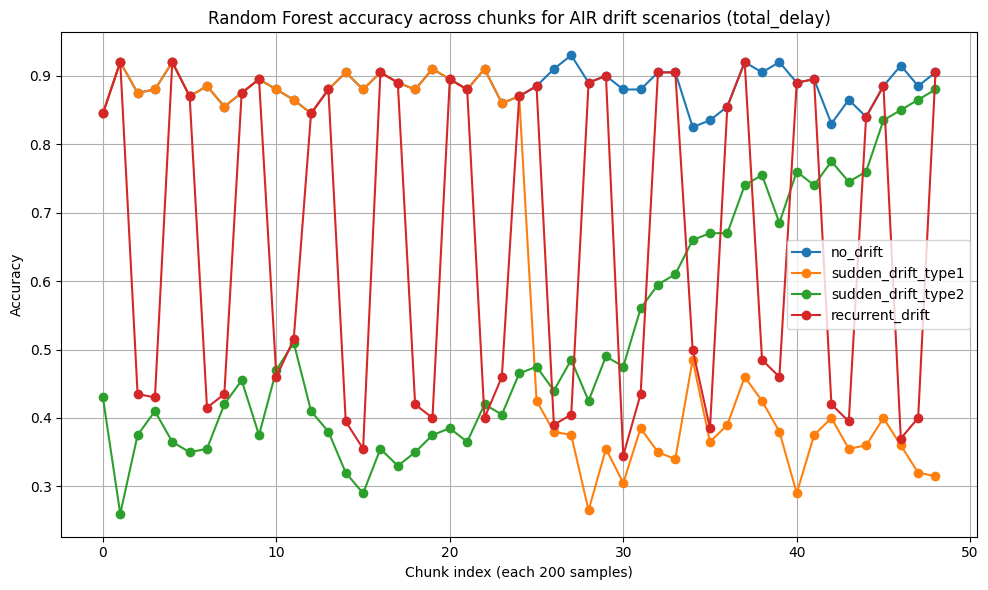

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ===================================================
# assume these AIR drift dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

chunk_size = 200
target = "total_delay"

# ===================================================
# AIR feature columns (same as your RF pipeline)
# ===================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",
    # "CRSArrTime_min",  # enable if you engineered it
]

# ===================================================
# helper: HHMM -> minutes since midnight
# ===================================================
def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

# ===================================================
# preprocessing (applies SAME steps to base + drift sets)
# ===================================================
def prep_air(df_in):
    df_tmp = df_in.copy()
    df_tmp.columns = [c.strip() for c in df_tmp.columns]

    # drop index column
    if "Unnamed: 0" in df_tmp.columns:
        df_tmp = df_tmp.drop(columns=["Unnamed: 0"])

    # drop missing
    df_tmp = df_tmp.dropna().reset_index(drop=True)

    # engineer time features
    if "CRSDepTime" in df_tmp.columns:
        df_tmp["CRSDepTime_min"] = df_tmp["CRSDepTime"].apply(hhmm_to_minutes)

    if "CRSArrTime" in df_tmp.columns:
        df_tmp["CRSArrTime_min"] = df_tmp["CRSArrTime"].apply(hhmm_to_minutes)

    # drop original HHMM columns
    drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df_tmp.columns]
    if len(drop_time_cols) > 0:
        df_tmp = df_tmp.drop(columns=drop_time_cols)

    # keep only existing features
    feats = [c for c in feature_columns if c in df_tmp.columns]

    X = df_tmp[feats].copy()
    y = df_tmp[target].astype(int).values

    # force numeric if needed
    for c in feats:
        if X[c].dtype == "object":
            X[c] = pd.to_numeric(X[c], errors="coerce")

    mask = X.notna().all(axis=1)
    X = X.loc[mask].values
    y = y[mask.values]

    return X, y, feats


# ===================================================
# Train model on BASE AIR dataset (use df_nodrift)
# ===================================================
X_base, y_base, feats_used = prep_air(df_nodrift)

print("✅ Features used:", feats_used)
print("✅ Base shape:", X_base.shape, "Target shape:", y_base.shape)

scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_base_scaled, y_base, test_size=0.3, random_state=42, stratify=y_base
)

# model (Random Forest)
model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# optional base test
y_test_pred = model.predict(X_test)
print("✅ Base Test Accuracy:", accuracy_score(y_test, y_test_pred))


# ===================================================
# Evaluate trained model on each drift dataset (chunk-wise)
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod, y_mod, _ = prep_air(df_mod)

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict (NO probabilities, direct class)
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Random Forest accuracy across chunks for AIR drift scenarios (total_delay)")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_sudden_type1

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type
0,2000.000000,7.000000,1.000000,56.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,510.000000,0,sudden_type1
1,1999.000000,1.000000,6.000000,60.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,630.000000,1,sudden_type1
2,2000.000000,5.000000,1.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,1040.000000,1,sudden_type1
3,1999.000000,4.000000,3.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,795.000000,0,sudden_type1
4,1999.000000,10.000000,5.000000,58.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,420.000000,0,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,1994.403837,-6.278996,6.477337,539.142944,-2224.643283,65.943993,-165.468086,113.300063,-293.839434,3188.549937,1,sudden_type1
9985,1998.048875,-24.747719,7.643774,852.639684,759.980465,85.552614,-186.417484,51.453889,-232.400111,1362.624405,0,sudden_type1
9986,1997.975042,-8.961709,-0.060109,508.878976,-1678.386260,55.441833,61.986245,20.321699,-356.343109,1792.461409,1,sudden_type1
9987,1998.689273,-24.255989,-1.512219,259.736530,-54.134539,43.071636,-120.744841,94.517382,-224.765051,2000.260238,1,sudden_type1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# AIR DATASET – Random Forest (saves predictions CSV)
# Dataset: df_sudden_type1 (AIR)
# Target: total_delay (0/1)
# ============================================================

# === Load your dataset (AIR drift frame) ===
df = df_sudden_type1

# === Clean column names ===
df.columns = [col.strip() for col in df.columns]

# === Drop index-like column if exists ===
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# === Drop missing values ===
df = df.dropna().reset_index(drop=True)

# ============================================================
# Time Feature Engineering: CRSDepTime -> CRSDepTime_min
# ============================================================
def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

if "CRSDepTime" in df.columns:
    df["CRSDepTime_min"] = df["CRSDepTime"].apply(hhmm_to_minutes)

if "CRSArrTime" in df.columns:
    df["CRSArrTime_min"] = df["CRSArrTime"].apply(hhmm_to_minutes)

drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df.columns]
if len(drop_time_cols) > 0:
    df = df.drop(columns=drop_time_cols)

# ============================================================
# Define feature_columns and target
# ============================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",
    # "CRSArrTime_min",
]
target = "total_delay"

feature_columns = [c for c in feature_columns if c in df.columns]

X = df[feature_columns].copy()
y = df[target].astype(int).values

# Force numeric safety
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y[mask.values]

# ============================================================
# Show class counts (so you SEE the issue clearly)
# ============================================================
unique, counts = np.unique(y, return_counts=True)
print("\n✅ total_delay class distribution:", dict(zip(unique, counts)))

# If only one class exists, training a classifier is meaningless
if len(unique) < 2:
    raise ValueError(
        f"total_delay has only ONE class in this dataset after cleaning: {unique}. "
        f"Cannot train/test a classifier. Use a different drift dataframe or check labels."
    )

# ============================================================
# Split data (stratify ONLY if valid)
# ============================================================
can_stratify = np.min(counts) >= 2

if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
else:
    print("⚠️ Stratify disabled (a class has <2 samples). Doing normal split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

# ============================================================
# Scaling (optional for RF)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# Train Random Forest
# ============================================================
model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
model.fit(X_train_scaled, y_train)

# ============================================================
# Predict + Confusion Matrix + Save CSV
# ============================================================
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

df_results = pd.DataFrame(X_test.reset_index(drop=True), columns=feature_columns)
df_results["total_delay"] = y_test
df_results["predicted_class"] = y_pred

df_results.to_csv("air_rf_predictions.csv", index=False)
print("\nPredictions saved to: air_rf_predictions.csv")

print("\nSample predictions:")
print(df_results.head())


✅ total_delay class distribution: {np.int64(0): np.int64(4913), np.int64(1): np.int64(5076)}

Confusion Matrix:
[[ 779  695]
 [ 480 1043]]

Predictions saved to: air_rf_predictions.csv

Sample predictions:
          Year      Month  DayOfWeek  CRSElapsedTime     Distance  origin_lat  \
0  1999.000000   3.000000   2.000000      123.000000   802.000000   32.895951   
1  1999.000000   6.000000   5.000000      153.000000   925.000000   41.979595   
2  1994.362058  24.218886  -9.862275      329.191028 -5309.026062   -4.072387   
3  1999.000000   1.000000   4.000000       60.000000   227.000000   33.640444   
4  1996.870556 -21.796099  -4.688417     -135.962515 -2508.649514  103.944373   

   origin_long   dest_lat   dest_long  CRSDepTime_min  total_delay  \
0   -97.037200  41.979595  -87.904464        0.000000            1   
1   -87.904464  29.980472  -95.339722        0.000000            1   
2   -61.640712  53.375010 -322.569370    -1432.488261            1   
3   -84.426944  35.214011 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# AIR DATASET – Random Forest Classification
# Uses df_sudden_type1 (AIR drift dataset)
# Target: total_delay (binary)
# ============================================================

# === Load dataset ===
df = df_sudden_type1.copy()

# === Clean column names ===
df.columns = [col.strip() for col in df.columns]

# === Drop missing values ===
df = df.dropna().reset_index(drop=True)

# ============================================================
# AIR FEATURES + TARGET
# ============================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]
target_col = "total_delay"

# Keep only columns that exist (safety)
feature_columns = [c for c in feature_columns if c in df.columns]

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {list(df.columns)}")

# === Select Features and Target ===
X = df[feature_columns].copy()
y = df[target_col].astype(int).copy()

# Force numeric conversion if any column is object
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Drop any NaNs created by coercion (align X and y)
mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# ============================================================
# Robust stratify (prevents "least populated class has only 1")
# ============================================================
counts = y.value_counts()
print("\n✅ total_delay class distribution:")
print(counts)

can_stratify = (counts.shape[0] >= 2) and (counts.min() >= 2)

# === Split data ===
if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print("✅ Using stratified split.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=True
    )
    print("⚠️ Stratify disabled (a class has <2 samples). Using normal split.")

# ============================================================
# Scaling (not needed for RF, kept only for pipeline consistency)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# Random Forest
# ============================================================
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train_scaled, y_train)

# === Predict ===
y_pred = rf.predict(X_test_scaled)

# === Evaluation ===
print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# ============================================================
# Save predictions like your reference script
# (Use original unscaled feature values for readability)
# ============================================================
df_results = X_test.copy()
df_results["true_class"] = y_test.values
df_results["predicted_class"] = y_pred

df_results.to_csv("air_rf_predictions.csv", index=False)
print("\n✅ Predictions saved to: air_rf_predictions.csv")

print("\n✅ Sample predictions:")
print(df_results.head())



✅ total_delay class distribution:
total_delay
1    5076
0    4913
Name: count, dtype: int64
✅ Using stratified split.

✅ Confusion Matrix:
[[ 779  695]
 [ 480 1043]]

✅ Classification Report:
              precision    recall  f1-score   support

           0     0.6187    0.5285    0.5701      1474
           1     0.6001    0.6848    0.6397      1523

    accuracy                         0.6079      2997
   macro avg     0.6094    0.6067    0.6049      2997
weighted avg     0.6093    0.6079    0.6054      2997

✅ Accuracy: 0.6079412746079412

✅ Predictions saved to: air_rf_predictions.csv

✅ Sample predictions:
             Year      Month  DayOfWeek  CRSElapsedTime     Distance  \
2063  1999.000000   3.000000   2.000000      123.000000   802.000000   
3601  1999.000000   6.000000   5.000000      153.000000   925.000000   
8797  1994.362058  24.218886  -9.862275      329.191028 -5309.026062   
2896  1999.000000   1.000000   4.000000       60.000000   227.000000   
7000  1996.870556 

In [ ]:
df_results

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,true_class,predicted_class
2063,1999.000000,3.000000,2.000000,123.000000,802.000000,32.895951,-97.037200,41.979595,-87.904464,0.000000,1,0
3601,1999.000000,6.000000,5.000000,153.000000,925.000000,41.979595,-87.904464,29.980472,-95.339722,0.000000,1,0
8797,1994.362058,24.218886,-9.862275,329.191028,-5309.026062,-4.072387,-61.640712,53.375010,-322.569370,-1432.488261,1,1
2896,1999.000000,1.000000,4.000000,60.000000,227.000000,33.640444,-84.426944,35.214011,-80.943126,810.000000,0,0
7000,1996.870556,-21.796099,-4.688417,-135.962515,-2508.649514,103.944373,140.299182,90.528540,-234.336655,1435.595366,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2793,2000.000000,7.000000,1.000000,219.000000,1501.000000,44.880547,-93.216922,25.793250,-80.290556,785.000000,1,0
5440,1996.527231,-34.615309,28.635888,178.880162,-1107.012746,64.374973,-159.407532,76.924605,-170.229375,3219.371927,1,1
5509,1999.162816,-18.929115,28.583728,581.710130,-139.684304,53.292533,17.198993,67.135360,-210.063653,212.823077,1,0
5478,1998.016122,-6.351981,13.371302,1009.700524,6373.366511,83.408644,17.445710,35.545830,-146.370685,1790.398415,1,1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ============================================================
# AIRLINE: Load dataset
# ============================================================
df = df_sudden_type1.copy()
df.columns = [c.strip() for c in df.columns]
df = df.dropna().reset_index(drop=True)

# ============================================================
# AIRLINE: Features + Target
# ============================================================
feature_columns = [
    "Year", "Month", "DayOfWeek", "CRSElapsedTime", "Distance",
    "origin_lat", "origin_long", "dest_lat", "dest_long", "CRSDepTime_min"
]
target_col = "total_delay"

# Keep only columns that exist (safety)
feature_columns = [c for c in feature_columns if c in df.columns]
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available: {list(df.columns)}")

X = df[feature_columns].copy()
y = df[target_col].astype(int).copy()

# Force numeric conversion for safety
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Drop NaNs created by coercion (align X and y)
mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# Robust stratify check
counts = y.value_counts()
print("\n✅ total_delay class distribution:")
print(counts)

can_stratify = (counts.shape[0] >= 2) and (counts.min() >= 2)

if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    print("✅ Using stratified split.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, shuffle=True
    )
    print("⚠️ Stratify disabled. Using normal split.")

print("Train:", X_train.shape, "Test:", X_test.shape)



✅ total_delay class distribution:
total_delay
1    5076
0    4913
Name: count, dtype: int64
✅ Using stratified split.
Train: (6992, 10) Test: (2997, 10)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# Scaling (not required for RF, kept for consistency)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# MLaaS (Black-box) Model: RandomForest
# ============================================================
mlaas_model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
mlaas_model.fit(X_train_scaled, y_train)

# Predict
y_pred = mlaas_model.predict(X_test_scaled)

# Evaluation
print("\n✅ [MLaaS Confusion Matrix]")
print(confusion_matrix(y_test, y_pred))

print("\n✅ [MLaaS Classification Report]")
print(classification_report(y_test, y_pred, digits=4))

acc_mlaas = accuracy_score(y_test, y_pred)
print(f"✅ [MLaaS vs GT] Accuracy: {acc_mlaas:.4f}")

# Build df_results using original (unscaled) values
df_results = X_test.copy()
df_results["true_class"] = y_test.values
df_results["predicted_class"] = y_pred.astype(int)

pred_csv = "air_rf_predictions_with_features.csv"
df_results.to_csv(pred_csv, index=False)
print(f"\n✅ Saved: {pred_csv}")

df_results.head()



✅ [MLaaS Confusion Matrix]
[[ 779  695]
 [ 480 1043]]

✅ [MLaaS Classification Report]
              precision    recall  f1-score   support

           0     0.6187    0.5285    0.5701      1474
           1     0.6001    0.6848    0.6397      1523

    accuracy                         0.6079      2997
   macro avg     0.6094    0.6067    0.6049      2997
weighted avg     0.6093    0.6079    0.6054      2997

✅ [MLaaS vs GT] Accuracy: 0.6079

✅ Saved: air_rf_predictions_with_features.csv


,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,true_class,predicted_class
2063,1999.000000,3.000000,2.000000,123.000000,802.000000,32.895951,-97.037200,41.979595,-87.904464,0.000000,1,0
3601,1999.000000,6.000000,5.000000,153.000000,925.000000,41.979595,-87.904464,29.980472,-95.339722,0.000000,1,0
8797,1994.362058,24.218886,-9.862275,329.191028,-5309.026062,-4.072387,-61.640712,53.375010,-322.569370,-1432.488261,1,1
2896,1999.000000,1.000000,4.000000,60.000000,227.000000,33.640444,-84.426944,35.214011,-80.943126,810.000000,0,0
7000,1996.870556,-21.796099,-4.688417,-135.962515,-2508.649514,103.944373,140.299182,90.528540,-234.336655,1435.595366,1,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

USE_F1 = True

features = feature_columns  # same features used above

X_all = df_results[features].values
y_true = df_results["true_class"].values.astype(int)
y_mlaas = df_results["predicted_class"].values.astype(int)

# Surrogate train/test split (IMPORTANT: no cheating)
X_train_s, X_test_s, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42,
    stratify=y_true if len(np.unique(y_true)) > 1 else None
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train_s, y_mlaas_train)

y_sur_test = surrogate.predict(X_test_s)

# (A) Mimicry: surrogate vs MLaaS
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# (B) Surrogate vs Ground Truth
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
print(f"[Surrogate vs GT] Accuracy (test): {acc_sur_gt:.4f}")

if USE_F1:
    f1_mlaas = f1_score(y_true, y_mlaas, average="macro")   # overall (on df_results)
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")
    print(f"[MLaaS vs GT] Macro-F1 (overall): {f1_mlaas:.4f}")
    print(f"[Surrogate vs GT] Macro-F1 (test): {f1_sur_gt:.4f}")


[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.8933
[Surrogate vs GT] Accuracy (test): 0.6133
[MLaaS vs GT] Macro-F1 (overall): 0.6049
[Surrogate vs GT] Macro-F1 (test): 0.6133


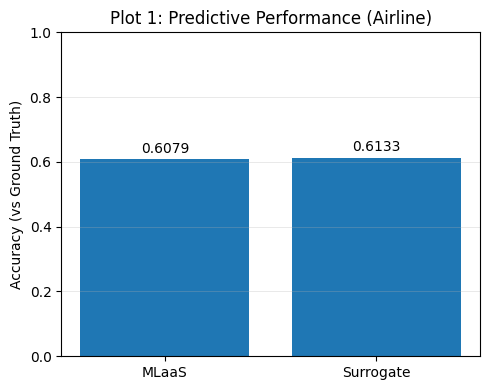

[Agreement Decomposition] Sum check: 1.000000


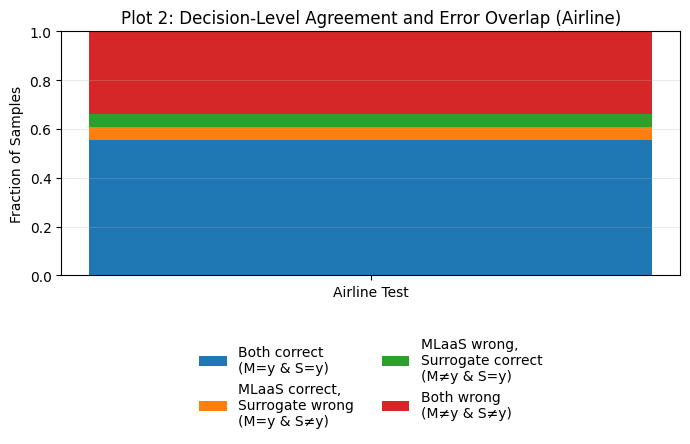


[Confusion Matrix] MLaaS vs GT (surrogate test split):
[[239 204]
 [150 307]]

[Confusion Matrix] Surrogate vs GT (surrogate test split):
[[279 164]
 [184 273]]

[Classification Report] Surrogate vs GT (test):
              precision    recall  f1-score   support

           0     0.6026    0.6298    0.6159       443
           1     0.6247    0.5974    0.6107       457

    accuracy                         0.6133       900
   macro avg     0.6137    0.6136    0.6133       900
weighted avg     0.6138    0.6133    0.6133       900



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Plot 1: MLaaS vs Surrogate accuracy vs Ground Truth
# ----------------------------
labels = ["MLaaS", "Surrogate"]
values = [acc_mlaas, acc_sur_gt]

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy (vs Ground Truth)")
plt.title("Plot 1: Predictive Performance (Airline)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Decision-level agreement/error decomposition
# ----------------------------
both_correct = np.mean((y_mlaas_test == y_true_test) & (y_sur_test == y_true_test))
mlaas_only   = np.mean((y_mlaas_test == y_true_test) & (y_sur_test != y_true_test))
sur_only     = np.mean((y_mlaas_test != y_true_test) & (y_sur_test == y_true_test))
both_wrong   = np.mean((y_mlaas_test != y_true_test) & (y_sur_test != y_true_test))

total = both_correct + mlaas_only + sur_only + both_wrong
print(f"[Agreement Decomposition] Sum check: {total:.6f}")

components = [both_correct, mlaas_only, sur_only, both_wrong]
names = [
    "Both correct\n(M=y & S=y)",
    "MLaaS correct,\nSurrogate wrong\n(M=y & S≠y)",
    "MLaaS wrong,\nSurrogate correct\n(M≠y & S=y)",
    "Both wrong\n(M≠y & S≠y)"
]

plt.figure(figsize=(7, 4.8))
bottom = 0.0
for c, n in zip(components, names):
    plt.bar(["Airline Test"], [c], bottom=bottom, label=n)
    bottom += c

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples")
plt.title("Plot 2: Decision-Level Agreement and Error Overlap (Airline)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# ----------------------------
# Extra: confusion matrices
# ----------------------------
print("\n[Confusion Matrix] MLaaS vs GT (surrogate test split):")
print(confusion_matrix(y_true_test, y_mlaas_test))

print("\n[Confusion Matrix] Surrogate vs GT (surrogate test split):")
print(confusion_matrix(y_true_test, y_sur_test))

print("\n[Classification Report] Surrogate vs GT (test):")
print(classification_report(y_true_test, y_sur_test, digits=4))


In [ ]:
import pandas as pd

# ============================================================
# CSV 1: Summary
# ============================================================
summary = {
    "dataset": ["Airline"],
    "mlaas_accuracy_vs_ground_truth": [acc_mlaas],
    "surrogate_accuracy_vs_ground_truth": [acc_sur_gt],
    "surrogate_mimicry_accuracy_vs_mlaas": [acc_mimic],
    "surrogate_model": ["DecisionTree"],
    "surrogate_max_depth": [4],
    "test_size": [0.30]
}

if USE_F1:
    summary["mlaas_macro_f1_vs_ground_truth"] = [f1_mlaas]
    summary["surrogate_macro_f1_vs_ground_truth"] = [f1_sur_gt]

df_summary = pd.DataFrame(summary)
summary_csv = "air_surrogate_fidelity_summary.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"✅ Saved: {summary_csv}")

# ============================================================
# CSV 2: Agreement decomposition
# ============================================================
df_agreement = pd.DataFrame([{
    "dataset": "Airline",
    "both_correct_fraction": both_correct,
    "mlaas_correct_surrogate_wrong_fraction": mlaas_only,
    "mlaas_wrong_surrogate_correct_fraction": sur_only,
    "both_wrong_fraction": both_wrong
}])

agreement_csv = "air_surrogate_agreement_decomposition.csv"
df_agreement.to_csv(agreement_csv, index=False)
print(f"✅ Saved: {agreement_csv}")

df_summary, df_agreement


✅ Saved: air_surrogate_fidelity_summary.csv
✅ Saved: air_surrogate_agreement_decomposition.csv


(   dataset  mlaas_accuracy_vs_ground_truth  \
 0  Airline                        0.607941   
 
    surrogate_accuracy_vs_ground_truth  surrogate_mimicry_accuracy_vs_mlaas  \
 0                            0.613333                             0.893333   
 
   surrogate_model  surrogate_max_depth  test_size  \
 0    DecisionTree                    4        0.3   
 
    mlaas_macro_f1_vs_ground_truth  surrogate_macro_f1_vs_ground_truth  
 0                        0.604875                            0.613316  ,
    dataset  both_correct_fraction  mlaas_correct_surrogate_wrong_fraction  \
 0  Airline               0.556667                                    0.05   
 
    mlaas_wrong_surrogate_correct_fraction  both_wrong_fraction  
 0                                0.056667             0.336667  )

**Weather**
---

In [ ]:
from google.colab import drive
import pandas as pd
#rive.mount('/content/drive')
df = pd.read_csv("weatherHistory 2.csv")
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
12295,2007-01-05 07:00:00.000 +0100,Overcast,rain,2.466667,-0.122222,0.99,9.0965,202.0,5.5384,0.0,1018.42,Mostly cloudy until night.
12296,2007-01-05 08:00:00.000 +0100,Partly Cloudy,rain,2.316667,-0.377778,0.99,9.3863,204.0,4.2987,0.0,1018.41,Mostly cloudy until night.
12297,2007-01-05 09:00:00.000 +0100,Clear,rain,2.966667,0.905556,0.99,7.5187,177.0,4.7495,0.0,1019.08,Mostly cloudy until night.
12298,2007-01-05 10:00:00.000 +0100,Partly Cloudy,rain,5.927778,3.522222,0.87,11.3344,243.0,9.6278,0.0,1019.53,Mostly cloudy until night.


In [ ]:
# === Import Libraries ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Fix any typos in column names
df.columns = [col.strip().replace('Loud', 'Cloud') for col in df.columns]

# Drop missing values
df = df.dropna()

# === Step 2: Encode Target Variable ===
# Convert 'Precip Type' → 1 for rain, 0 for snow
df['Rain'] = df['Precip Type'].apply(lambda x: 1 if str(x).lower() == 'rain' else 0)

# === Step 3: Select Features ===
X = df[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Wind Bearing (degrees)',
        'Visibility (km)', 'Cloud Cover', 'Pressure (millibars)']]
y = df['Rain']

# === Step 4: Split Dataset ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === Step 5: Feature Scaling ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Step 6: Build ANN Model ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input + 1st hidden layer
    Dropout(0.3),  # Prevent overfitting
    Dense(32, activation='relu'),  # 2nd hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer (binary)
])

# === Step 7: Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# === Step 8: Train Model ===
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# === Step 9: Evaluate Model ===
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))


Epoch 1/5


/tmp/ipython-input-1021740380.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rain'] = df['Precip Type'].apply(lambda x: 1 if str(x).lower() == 'rain' else 0)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7438 - loss: 0.4820 - val_accuracy: 0.9419 - val_loss: 0.1622
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9354 - loss: 0.1672 - val_accuracy: 0.9669 - val_loss: 0.0984
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9473 - loss: 0.1305 - val_accuracy: 0.9715 - val_loss: 0.0794
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9570 - loss: 0.1025 - val_accuracy: 0.9762 - val_loss: 0.0611
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9643 - loss: 0.0830 - val_accuracy: 0.9750 - val_loss: 0.0623
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Confusion Matrix:
[[ 494   81]
 [  21 3094]]

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       575
           1       0.97      0.99      0.98      3115

    accuracy                           0.97      3690
   macro avg       0.97      0.93      0.9

In [ ]:
# Example: filter and reorder DataFrame columns
selected_columns = [
    'Temperature (C)',
    'Apparent Temperature (C)',
    'Humidity',
    'Wind Speed (km/h)',
    'Wind Bearing (degrees)',
    'Visibility (km)',
    'Cloud Cover',
    'Pressure (millibars)',
    'Rain'  # keep Range at the end
]

# Keep only these columns (ignore missing ones if not present)
df = df[[col for col in selected_columns if col in df.columns]]

# Verify result
print(df.head())
df['Rain'].value_counts()
df.to_csv("drift.csv")

   Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0         9.472222                  7.388889      0.89            14.1197   
1         9.355556                  7.227778      0.86            14.2646   
2         9.377778                  9.377778      0.89             3.9284   
3         8.288889                  5.944444      0.83            14.1036   
4         8.755556                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Cloud Cover  Pressure (millibars)  \
0                   251.0          15.8263          0.0               1015.13   
1                   259.0          15.8263          0.0               1015.63   
2                   204.0          14.9569          0.0               1015.94   
3                   269.0          15.8263          0.0               1016.41   
4                   259.0          15.8263          0.0               1016.51   

   Rain  
0     1  
1     1  
2     1  
3     1  


**Weather Drift Injection**


In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "drift.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("wether_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("wether_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("wether_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("wether_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

In [ ]:
import pandas as pd
# Load the datasets
df_sudden_type1 = pd.read_csv("/content/wether_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/wether_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("wether_recurrent_drift.csv")
df_nodrift      = pd.read_csv("wether_no_drift.csv")
# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"
# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

Merged dataset saved to 'har_all_drifts.csv'


In [ ]:
df_sudden_type1

,Unnamed: 0,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Rain,drift_type
0,0.0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,1,sudden_type1
1,1.0,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,1,sudden_type1
2,2.0,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,1,sudden_type1
3,3.0,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,1,sudden_type1
4,4.0,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,1,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...
12294,12294.0,2.338889,-0.372222,0.99,9.4668,213.0,5.2164,0.0,1017.79,1,sudden_type1
12295,12295.0,2.466667,-0.122222,0.99,9.0965,202.0,5.5384,0.0,1018.42,1,sudden_type1
12296,12296.0,2.316667,-0.377778,0.99,9.3863,204.0,4.2987,0.0,1018.41,1,sudden_type1
12297,12297.0,2.966667,0.905556,0.99,7.5187,177.0,4.7495,0.0,1019.08,1,sudden_type1


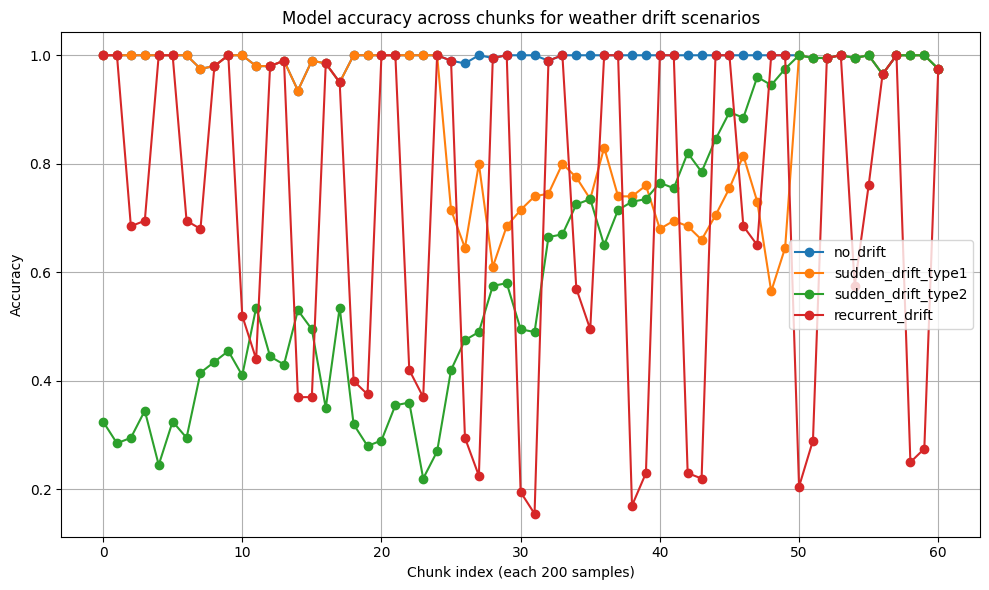

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# ===================================================
# assume these weather drift dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

# ===================================================
# define features and target
# ===================================================
features = [
    "Temperature (C)", "Apparent Temperature (C)", "Humidity",
    "Wind Speed (km/h)", "Wind Bearing (degrees)",
    "Visibility (km)", "Cloud Cover", "Pressure (millibars)"
]
target = "Rain"

chunk_size = 200

# ===================================================
# load main weather dataset and train model
# ===================================================
# note: df is your main base dataset (e.g., df_nodrift)
X = df[features].values
y = df[target].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y, test_size=0.3, random_state=42
)

# model (same architecture)
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                      solver='adam', max_iter=300, random_state=42)
model.fit(X_train, y_train)

# ===================================================
# Evaluate trained model on each drift dataset
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod = df_mod[features].values
    y_mod = df_mod[target].values

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Model accuracy across chunks for weather drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ============================================================
# WEATHER: Load dataframe
# ============================================================
df = df_sudden_type1.copy()
df.columns = [c.strip().replace("Loud", "Cloud") for c in df.columns]
df = df.dropna().reset_index(drop=True)

# ============================================================
# WEATHER: features + target
# ============================================================
features = [
    "Temperature (C)", "Apparent Temperature (C)", "Humidity",
    "Wind Speed (km/h)", "Wind Bearing (degrees)",
    "Visibility (km)", "Cloud Cover", "Pressure (millibars)"
]
target = "Rain"

# Encode labels (Rain / No Rain)
le = LabelEncoder()
y_enc = le.fit_transform(df[target].values)

X = df[features].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)
print("Classes:", list(le.classes_))


Train: (8609, 8) Test: (3690, 8)
Classes: [np.int64(0), np.int64(1)]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# ============================================================
# ANN model (binary)
# ============================================================
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predict (MLaaS outputs)
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n[MLaaS Confusion Matrix]")
print(confusion_matrix(y_test, y_pred))

# Build df_results (IMPORTANT: store ORIGINAL unscaled features for readability)
df_results = pd.DataFrame(X_test, columns=features)
df_results["true_class"] = le.inverse_transform(y_test)
df_results["predicted_class"] = le.inverse_transform(y_pred)

pred_csv = "weather_predictions_with_features.csv"
df_results.to_csv(pred_csv, index=False)
print(f"\nSaved: {pred_csv}")
df_results.head()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8065 - loss: 0.4568 - val_accuracy: 0.9408 - val_loss: 0.2548
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9194 - loss: 0.2565 - val_accuracy: 0.9588 - val_loss: 0.2031
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9407 - loss: 0.2108 - val_accuracy: 0.9646 - val_loss: 0.1866
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9405 - loss: 0.2088 - val_accuracy: 0.9686 - val_loss: 0.1681
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9515 - loss: 0.1713 - val_accuracy: 0.9681 - val_loss: 0.1581
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

[MLaaS Confusion Matrix]
[[1865   77]
 [  77 1671]]

Saved: weather_predictions_with_features.csv


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),true_class,predicted_class
0,-63.109611,-40.328322,-0.256508,5.620724,-532.132259,5.065667,0.0,170.313858,1,0
1,-15.828119,-13.490084,0.747088,18.563361,1072.246356,31.654057,0.0,466.127999,0,0
2,-38.905793,44.635026,-0.026081,-18.078020,502.007172,23.713983,0.0,1566.255441,0,0
3,-11.866667,-11.866667,0.860000,1.835400,26.000000,9.547300,0.0,1042.310000,0,0
4,-48.889483,-94.082843,0.040552,74.630953,606.166021,18.145262,0.0,1019.256690,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

X_all = df_results[features].values
y_true = y_true_all
y_mlaas = y_mlaas_all

# Proper split (no cheating)
X_train_s, X_test_s, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42, stratify=y_true
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train_s, y_mlaas_train)

y_sur_test = surrogate.predict(X_test_s)

# Mimicry: surrogate vs MLaaS
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# Surrogate vs GT
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
print(f"[Surrogate vs GT] Accuracy (test): {acc_sur_gt:.4f}")

if USE_F1:
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")
    print(f"[Surrogate vs GT] Macro-F1 (test):  {f1_sur_gt:.4f}")


[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.9702
[Surrogate vs GT] Accuracy (test): 0.9341
[Surrogate vs GT] Macro-F1 (test):  0.9340


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

USE_F1 = True

# Encode to numeric for metrics (safe)
le_true = LabelEncoder()
y_true_all = le_true.fit_transform(df_results["true_class"].values)

le_pred = LabelEncoder()
y_mlaas_all = le_pred.fit_transform(df_results["predicted_class"].values)

acc_mlaas = accuracy_score(y_true_all, y_mlaas_all)
print(f"[MLaaS vs GT] Accuracy: {acc_mlaas:.4f}")

if USE_F1:
    f1_mlaas = f1_score(y_true_all, y_mlaas_all, average="macro")
    print(f"[MLaaS vs GT] Macro-F1:  {f1_mlaas:.4f}")


[MLaaS vs GT] Accuracy: 0.9583
[MLaaS vs GT] Macro-F1:  0.9581


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

X_all = df_results[features].values
y_true = y_true_all
y_mlaas = y_mlaas_all

# Proper split (no cheating)
X_train_s, X_test_s, y_mlaas_train, y_mlaas_test, y_true_train, y_true_test = train_test_split(
    X_all, y_mlaas, y_true,
    test_size=0.30, random_state=42, stratify=y_true
)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train_s, y_mlaas_train)

y_sur_test = surrogate.predict(X_test_s)

# Mimicry: surrogate vs MLaaS
acc_mimic = accuracy_score(y_mlaas_test, y_sur_test)
print(f"[Surrogate vs MLaaS] Mimicry Accuracy (test): {acc_mimic:.4f}")

# Surrogate vs GT
acc_sur_gt = accuracy_score(y_true_test, y_sur_test)
print(f"[Surrogate vs GT] Accuracy (test): {acc_sur_gt:.4f}")

if USE_F1:
    f1_sur_gt = f1_score(y_true_test, y_sur_test, average="macro")
    print(f"[Surrogate vs GT] Macro-F1 (test):  {f1_sur_gt:.4f}")


[Surrogate vs MLaaS] Mimicry Accuracy (test): 0.9702
[Surrogate vs GT] Accuracy (test): 0.9341
[Surrogate vs GT] Macro-F1 (test):  0.9340


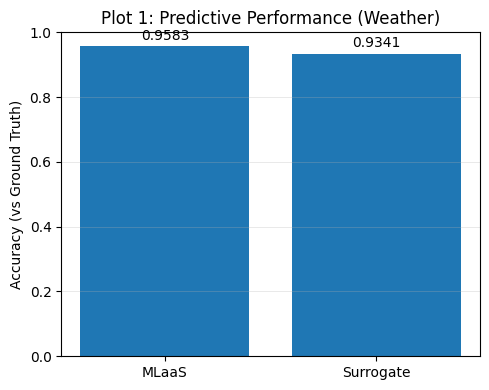

[Agreement Decomposition] Sum check: 1.000000


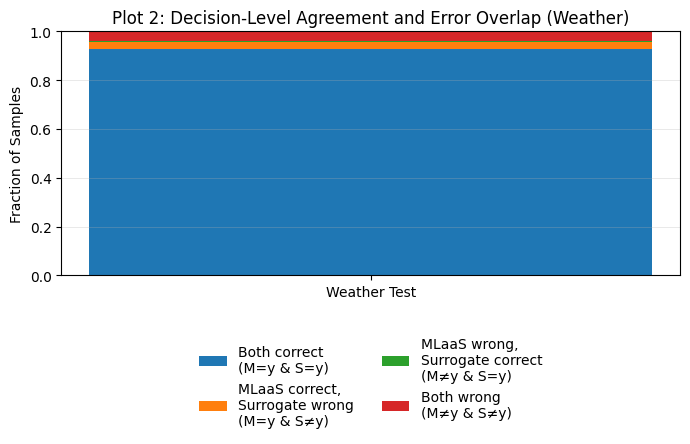


[Confusion Matrix] MLaaS vs GT (surrogate test split):
[[560  23]
 [ 27 497]]

[Confusion Matrix] Surrogate vs GT (surrogate test split):
[[535  48]
 [ 25 499]]

[Classification Report] Surrogate vs GT (test):
              precision    recall  f1-score   support

           0     0.9554    0.9177    0.9361       583
           1     0.9122    0.9523    0.9318       524

    accuracy                         0.9341      1107
   macro avg     0.9338    0.9350    0.9340      1107
weighted avg     0.9350    0.9341    0.9341      1107



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Plot 1: MLaaS vs Surrogate vs GT
# ----------------------------
labels = ["MLaaS", "Surrogate"]
values = [acc_mlaas, acc_sur_gt]

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy (vs Ground Truth)")
plt.title("Plot 1: Predictive Performance (Weather)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Agreement/Error decomposition
# ----------------------------
both_correct = np.mean((y_mlaas_test == y_true_test) & (y_sur_test == y_true_test))
mlaas_only   = np.mean((y_mlaas_test == y_true_test) & (y_sur_test != y_true_test))
sur_only     = np.mean((y_mlaas_test != y_true_test) & (y_sur_test == y_true_test))
both_wrong   = np.mean((y_mlaas_test != y_true_test) & (y_sur_test != y_true_test))

total = both_correct + mlaas_only + sur_only + both_wrong
print(f"[Agreement Decomposition] Sum check: {total:.6f}")

components = [both_correct, mlaas_only, sur_only, both_wrong]
names = [
    "Both correct\n(M=y & S=y)",
    "MLaaS correct,\nSurrogate wrong\n(M=y & S≠y)",
    "MLaaS wrong,\nSurrogate correct\n(M≠y & S=y)",
    "Both wrong\n(M≠y & S≠y)"
]

plt.figure(figsize=(7, 4.8))
bottom = 0.0
for c, n in zip(components, names):
    plt.bar(["Weather Test"], [c], bottom=bottom, label=n)
    bottom += c

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples")
plt.title("Plot 2: Decision-Level Agreement and Error Overlap (Weather)")
plt.grid(axis="y", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Extra: confusion matrices on surrogate test split
print("\n[Confusion Matrix] MLaaS vs GT (surrogate test split):")
print(confusion_matrix(y_true_test, y_mlaas_test))

print("\n[Confusion Matrix] Surrogate vs GT (surrogate test split):")
print(confusion_matrix(y_true_test, y_sur_test))

print("\n[Classification Report] Surrogate vs GT (test):")
print(classification_report(y_true_test, y_sur_test, digits=4))


In [ ]:
import pandas as pd

# ============================================================
# Summary CSV
# ============================================================
summary = {
    "dataset": ["Weather"],
    "mlaas_accuracy_vs_ground_truth": [acc_mlaas],
    "surrogate_accuracy_vs_ground_truth": [acc_sur_gt],
    "surrogate_mimicry_accuracy_vs_mlaas": [acc_mimic],
    "surrogate_model": ["DecisionTree"],
    "surrogate_max_depth": [4],
    "test_size": [0.30]
}

if USE_F1:
    summary["mlaas_macro_f1_vs_ground_truth"] = [f1_mlaas]
    summary["surrogate_macro_f1_vs_ground_truth"] = [f1_sur_gt]

df_summary = pd.DataFrame(summary)
summary_csv = "weather_surrogate_fidelity_summary.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"✅ Saved: {summary_csv}")

# ============================================================
# Agreement CSV
# ============================================================
df_agreement = pd.DataFrame([{
    "dataset": "Weather",
    "both_correct_fraction": both_correct,
    "mlaas_correct_surrogate_wrong_fraction": mlaas_only,
    "mlaas_wrong_surrogate_correct_fraction": sur_only,
    "both_wrong_fraction": both_wrong
}])

agreement_csv = "weather_surrogate_agreement_decomposition.csv"
df_agreement.to_csv(agreement_csv, index=False)
print(f"✅ Saved: {agreement_csv}")

df_summary, df_agreement

✅ Saved: weather_surrogate_fidelity_summary.csv
✅ Saved: weather_surrogate_agreement_decomposition.csv


(   dataset  mlaas_accuracy_vs_ground_truth  \
 0  Weather                        0.958266   
 
    surrogate_accuracy_vs_ground_truth  surrogate_mimicry_accuracy_vs_mlaas  \
 0                            0.934056                              0.97019   
 
   surrogate_model  surrogate_max_depth  test_size  \
 0    DecisionTree                    4        0.3   
 
    mlaas_macro_f1_vs_ground_truth  surrogate_macro_f1_vs_ground_truth  
 0                         0.95815                            0.933986  ,
    dataset  both_correct_fraction  mlaas_correct_surrogate_wrong_fraction  \
 0  Weather               0.929539                                0.025294   
 
    mlaas_wrong_surrogate_correct_fraction  both_wrong_fraction  
 0                                0.004517              0.04065  )

**VISULIZATION**
---

In [ ]:
df2=pd.read_csv("weather_surrogate_agreement_decomposition.csv")
df2

,dataset,both_correct_fraction,mlaas_correct_surrogate_wrong_fraction,mlaas_wrong_surrogate_correct_fraction,both_wrong_fraction
0,Weather,0.929539,0.025294,0.004517,0.04065


In [ ]:
import glob
import pandas as pd

# ============================================================
# Combine all summary CSV files into one DataFrame
# ============================================================

summary_files = sorted(glob.glob("*_surrogate_agreement_decomposition.csv"))

if len(summary_files) == 0:
    raise FileNotFoundError("No files found matching '*_surrogate_agreement_decomposition.csv' in current directory.")

df_list = []
for f in summary_files:
    tmp = pd.read_csv(f)
    tmp["source_file"] = f  # keep traceability
    df_list.append(tmp)

df_all_summary = pd.concat(df_list, ignore_index=True)

print("Files combined:")
for f in summary_files:
    print(" -", f)

print("\nCombined DataFrame shape:", df_all_summary.shape)
df_all_summary


Files combined:
 - air_surrogate_agreement_decomposition.csv
 - electricity_surrogate_agreement_decomposition.csv
 - har_surrogate_agreement_decomposition.csv
 - poker_surrogate_agreement_decomposition.csv
 - weather_surrogate_agreement_decomposition.csv

Combined DataFrame shape: (5, 6)


,dataset,both_correct_fraction,mlaas_correct_surrogate_wrong_fraction,mlaas_wrong_surrogate_correct_fraction,both_wrong_fraction,source_file
0,Airline,0.556667,0.050000,0.056667,0.336667,air_surrogate_agreement_decomposition.csv
1,Electricity,0.706791,0.027458,0.014464,0.251287,electricity_surrogate_agreement_decomposition.csv
2,HAR,0.448944,0.106111,0.054278,0.390667,har_surrogate_agreement_decomposition.csv
3,Poker,0.420667,0.135556,0.069722,0.374056,poker_surrogate_agreement_decomposition.csv
4,Weather,0.929539,0.025294,0.004517,0.040650,weather_surrogate_agreement_decomposition.csv


In [ ]:
df_all_summary.to_csv("stat2.csv")

In [ ]:
import glob
import pandas as pd

# ============================================================
# Combine all summary CSV files into one DataFrame
# ============================================================

summary_files = sorted(glob.glob("*_surrogate_fidelity_summary.csv"))

if len(summary_files) == 0:
    raise FileNotFoundError("No files found matching '*_surrogate_fidelity_summary.csv' in current directory.")

df_list = []
for f in summary_files:
    tmp = pd.read_csv(f)
    tmp["source_file"] = f  # keep traceability
    df_list.append(tmp)

df_all_summary = pd.concat(df_list, ignore_index=True)

print("Files combined:")
for f in summary_files:
    print(" -", f)

print("\nCombined DataFrame shape:", df_all_summary.shape)
df_all_summary


In [ ]:
import glob
import pandas as pd

# ============================================================
# Combine all summary CSV files into one DataFrame
# ============================================================

summary_files = sorted(glob.glob("*_surrogate_fidelity_summary.csv"))

if len(summary_files) == 0:
    raise FileNotFoundError("No files found matching '*_surrogate_fidelity_summary.csv' in current directory.")

df_list = []
for f in summary_files:
    tmp = pd.read_csv(f)
    tmp["source_file"] = f  # keep traceability
    df_list.append(tmp)

df_all_summary = pd.concat(df_list, ignore_index=True)

print("Files combined:")
for f in summary_files:
    print(" -", f)

print("\nCombined DataFrame shape:", df_all_summary.shape)
df_all_summary


Files combined:
 - air_surrogate_fidelity_summary.csv
 - electricity_surrogate_fidelity_summary.csv
 - har_surrogate_fidelity_summary.csv
 - poker_surrogate_fidelity_summary.csv
 - weather_surrogate_fidelity_summary.csv

Combined DataFrame shape: (5, 11)


,dataset,mlaas_accuracy_vs_ground_truth,surrogate_accuracy_vs_ground_truth,surrogate_mimicry_accuracy_vs_mlaas,surrogate_model,surrogate_max_depth,test_size,mlaas_macro_f1_vs_ground_truth,surrogate_macro_f1_vs_ground_truth,source_file,test_split_ratio
0,Airline,0.607941,0.613333,0.893333,DecisionTree,4,0.3,0.604875,0.613316,air_surrogate_fidelity_summary.csv,NaN
1,Electricity,0.727159,0.721255,0.958078,DecisionTree,4,NaN,0.716591,0.707778,electricity_surrogate_fidelity_summary.csv,0.3
2,HAR,0.557583,0.503222,0.702667,DecisionTree,4,0.3,0.521078,0.474914,har_surrogate_fidelity_summary.csv,NaN
3,Poker,0.559733,0.490389,0.749000,NaN,4,0.3,0.137253,0.088082,poker_surrogate_fidelity_summary.csv,NaN
4,Weather,0.958266,0.934056,0.970190,DecisionTree,4,0.3,0.958150,0.933986,weather_surrogate_fidelity_summary.csv,NaN


In [ ]:
df_all_summary.to_csv("stat.csv")

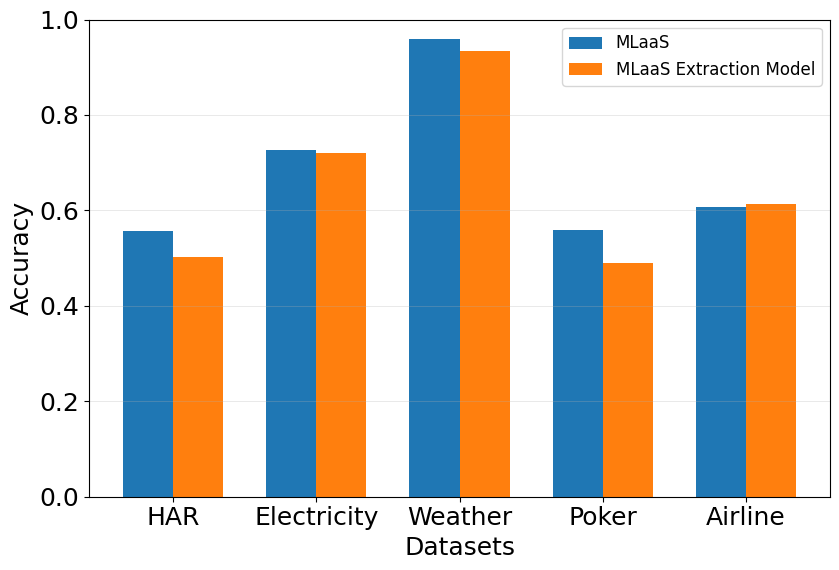

Saved: plot1_mlaas_vs_surrogate_accuracy.pdf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# FONT & STYLE CUSTOMIZATION (EDIT THESE)
# ============================================================
TITLE_SIZE = 14
BAR_WIDTH = 0.35
AXIS_LABEL_SIZE = 18
TICK_SIZE = 18
LEGEND_SIZE = 12

FIG_WIDTH = 8.5
FIG_HEIGHT = 5.8

# ============================================================
# Load CSV
# ============================================================
csv_path = "stat.csv"
df = pd.read_csv(csv_path)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# ============================================================
# Dataset ordering
# ============================================================
preferred_order = ["HAR", "Electricity", "Weather", "Poker"]
existing = [d for d in preferred_order if d in df["dataset"].values]
others = [d for d in df["dataset"].values if d not in existing]
order = existing + others

df = df.set_index("dataset").loc[order].reset_index()

datasets = df["dataset"].tolist()

# ============================================================
# Extract Accuracy Values
# ============================================================
acc_mlaas = df["mlaas_accuracy_vs_ground_truth"].to_numpy(dtype=float)
acc_sur   = df["surrogate_accuracy_vs_ground_truth"].to_numpy(dtype=float)

x = np.arange(len(datasets))

# ============================================================
# Plot
# ============================================================
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.bar(x - BAR_WIDTH/2, acc_mlaas, BAR_WIDTH, label="MLaaS")
plt.bar(x + BAR_WIDTH/2, acc_sur,   BAR_WIDTH, label="MLaaS Extraction Model")

plt.xticks(x, datasets, fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)

plt.ylim(0.0, 1.0)
plt.xlabel("Datasets", fontsize=AXIS_LABEL_SIZE)
plt.ylabel("Accuracy", fontsize=AXIS_LABEL_SIZE)
plt.grid(axis="y", linewidth=0.5, alpha=0.4)

plt.legend(fontsize=LEGEND_SIZE)

plt.tight_layout()

plot1_path = "plot1_mlaas_vs_surrogate_accuracy.pdf"
plt.savefig(plot1_path, dpi=300)
plt.show()


print("Saved:", plot1_path)





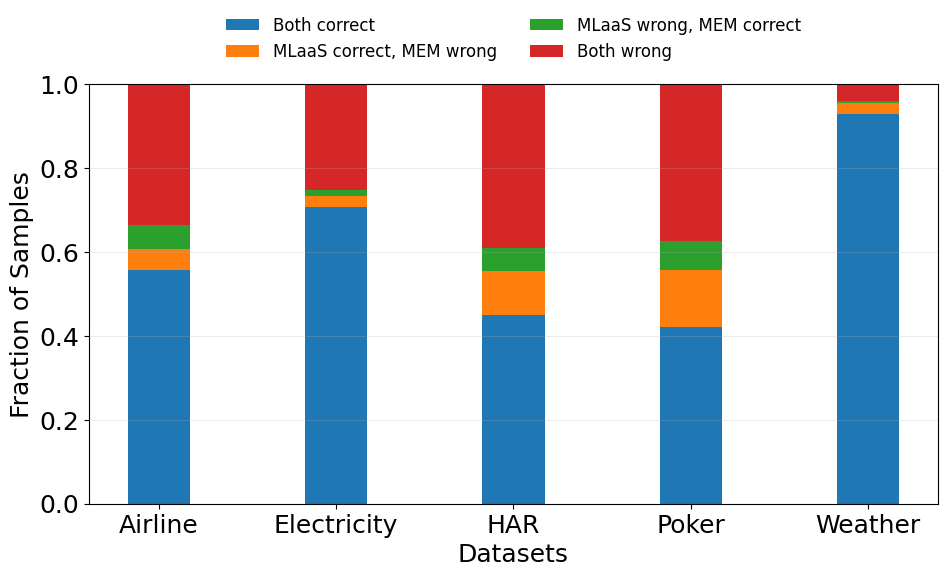

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Adjustable parameters
# ==========================

TITLE_SIZE = 14
BAR_WIDTH = 0.35
AXIS_LABEL_SIZE = 18
TICK_SIZE = 18
LEGEND_SIZE = 12

# ==========================
# Load CSV
# ==========================
df = pd.read_csv("stat2.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

datasets = df["dataset"].values
x = np.arange(len(datasets))

both_correct = df["both_correct_fraction"].values
mlaas_only   = df["mlaas_correct_surrogate_wrong_fraction"].values
sur_only     = df["mlaas_wrong_surrogate_correct_fraction"].values
both_wrong   = df["both_wrong_fraction"].values

# ==========================
# Plot
# ==========================
plt.figure(figsize=(9.5, 5.8))
b1 = plt.bar(x, both_correct, BAR_WIDTH)
b2 = plt.bar(x, mlaas_only, BAR_WIDTH, bottom=both_correct)
b3 = plt.bar(x, sur_only, BAR_WIDTH,
             bottom=both_correct + mlaas_only)
b4 = plt.bar(x, both_wrong, BAR_WIDTH,
             bottom=both_correct + mlaas_only + sur_only)

plt.xticks(x, datasets, fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)

plt.ylim(0, 1)
plt.ylabel("Fraction of Samples", fontsize=AXIS_LABEL_SIZE)
plt.xlabel("Datasets", fontsize=AXIS_LABEL_SIZE)
plt.grid(axis="y", linewidth=0.5, alpha=0.35)

# ==========================
# Legend on TOP (2x2 layout)
# ==========================
labels = [
    "Both correct",
    "MLaaS correct, MEM wrong",
    "MLaaS wrong, MEM correct",
    "Both wrong"
]

plt.legend([b1, b2, b3, b4],
           labels,
           loc="lower center",
           bbox_to_anchor=(0.5, 1.02),   # move legend just above plot
           ncol=2,
           fontsize=LEGEND_SIZE,
           frameon=False)

# Tight layout reduces extra white space
plt.tight_layout(pad=0.8)

plt.savefig(
    "agreement_plot.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300
)


plt.show()

# ==========================
# Save as PDF
# ==========================

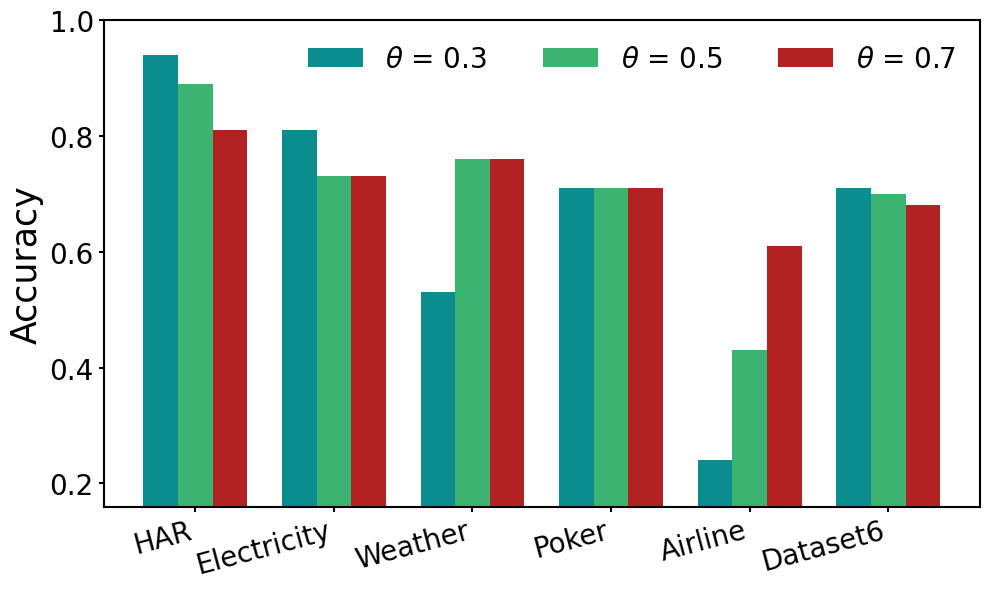

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# THRESHOLDS
# ============================================================
thresholds_to_plot = ["0.3", "0.5", "0.7"]

# Original threshold ordering in your arrays
Thresholds_All = ["0.1", "0.3", "0.5", "0.7"]
idx = {t: Thresholds_All.index(t) for t in thresholds_to_plot}

# ============================================================
# IMPORTANT:
# These are NOT techniques anymore.
# They are MDDP accuracies for DIFFERENT DATASETS.
# Replace dataset names below if needed.
# ============================================================
datasets = ["HAR", "Electricity", "Weather", "Poker", "Airline", "Dataset6"]

HAR_MDDP         = ["0.93","0.94","0.89","0.81"]  # (was MDDP_Accuracy)
ELECTRICITY_MDDP = ["0.27","0.81","0.73","0.73"]  # (was ADWIN_Accuracy)
WEATHER_MDDP     = ["0.31","0.53","0.76","0.76"]  # (was MDD_Accuracy)
POKER_MDDP       = ["0.70","0.71","0.71","0.71"]  # (was D3_Accuracy)
AIRLINE_MDDP     = ["0.10","0.24","0.43","0.61"]  # (was STUDD_Accuracy)

dataset_to_acc = {
    "HAR": HAR_MDDP,
    "Electricity": ELECTRICITY_MDDP,
    "Weather": WEATHER_MDDP,
    "Poker": POKER_MDDP,
    "Airline": AIRLINE_MDDP,
    "Dataset6": DATASET6_MDDP,
}

# ============================================================
# COLORS (threshold-based)
# ============================================================
thr_colors = {
    "0.3": "#0B8C8F",
    "0.5": "#3CB371",
    "0.7": "#B22222",
}

# ============================================================
# FIGURE / BAR GEOMETRY
# ============================================================
fig_w = 10
fig_h = 6
bar_w = 0.75  # total width of group per dataset

# ============================================================
# FONT SIZE CONTROLS
# ============================================================
title_fs  = 0    # set 0 to effectively remove title
ylabel_fs = 25
xtick_fs  = 20
ytick_fs  = 20
legend_fs = 20

# ============================================================
# AXIS / TICK THICKNESS
# ============================================================
spine_w = 1.5
tick_w  = 1.5

# ============================================================
# BUILD: threshold -> values across datasets
# ============================================================
acc_by_threshold = {}
for t in thresholds_to_plot:
    acc_by_threshold[t] = [float(dataset_to_acc[ds][idx[t]]) for ds in datasets]

# ============================================================
# PLOTTING (grouped bars: thresholds inside each dataset)
# ============================================================
x = np.arange(len(datasets))
nT = len(thresholds_to_plot)
single_bar_w = bar_w / nT
offsets = (np.arange(nT) - (nT - 1) / 2.0) * single_bar_w

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

all_vals = np.array([v for t in thresholds_to_plot for v in acc_by_threshold[t]])
ax.set_ylim(max(0.0, all_vals.min() - 0.08), 1.0)

for j, t in enumerate(thresholds_to_plot):
    vals = np.array(acc_by_threshold[t])
    xpos = x + offsets[j]
    ax.bar(xpos, vals, width=single_bar_w, color=thr_colors[t], label=rf"$\theta$ = {t}")

# X ticks
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=15, ha="right", fontsize=xtick_fs)

# Y label
ax.set_ylabel("Accuracy", fontsize=ylabel_fs)

# Remove title (as requested)
# ax.set_title("MDDP across datasets", fontsize=title_fs)  # keep commented

# Tick styling
ax.tick_params(axis="y", labelsize=ytick_fs, width=tick_w)
ax.tick_params(axis="x", labelsize=xtick_fs, width=tick_w)

# Spines
for spine in ax.spines.values():
    spine.set_linewidth(spine_w)

# Legend
ax.legend(frameon=False, fontsize=legend_fs, ncol=3)

ax.grid(False)
fig.tight_layout()

plt.show()

# Optional save
# fig.savefig("MDDP_Accuracy_Across_Datasets_theta_0.3_0.5_0.7.pdf", format="pdf", bbox_inches="tight")
